<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

<a id="top"></a>
[Back to report](#bottom)

In [1]:
# import the packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.functions import round, asc, desc
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression

### Step 1: Problem Statement Formulation

In [2]:
spark = SparkSession.builder.appName("Assignment 1").getOrCreate()

In [3]:
# load and explore data
hdb=spark.read.csv('./data/sg_flat_prices_mod.csv',header=True,inferSchema=True)
hdb.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  465|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|

In [4]:
hdb.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



In [5]:
# value based problem statement # why does it add value / why are we doing this
# to predict the resale prices of HDB resale transactions excluding resale prices more than 1 million

In [6]:
# show count of transactions per flat type
hdb.groupBy('flat_type').count().orderBy(asc('flat_type')).show()

+----------------+-----+
|       flat_type|count|
+----------------+-----+
|          1 ROOM|   29|
|          2 ROOM|  919|
|          3 ROOM|15589|
|          4 ROOM|26592|
|          5 ROOM|15916|
|       EXECUTIVE| 5169|
|MULTI-GENERATION|   33|
+----------------+-----+



In [7]:
# show count of transactions per town
hdb.groupBy('town').count().orderBy(desc('count')).show(26)

+---------------+-----+
|           town|count|
+---------------+-----+
|      WOODLANDS| 4988|
|       SENGKANG| 4970|
|    JURONG WEST| 4945|
|         YISHUN| 4333|
|       TAMPINES| 4080|
|        PUNGGOL| 4013|
|          BEDOK| 3429|
|        HOUGANG| 2982|
|     ANG MO KIO| 2917|
|  CHOA CHU KANG| 2660|
|    BUKIT MERAH| 2578|
|    BUKIT BATOK| 2451|
|  BUKIT PANJANG| 2384|
|      TOA PAYOH| 2184|
|KALLANG/WHAMPOA| 1916|
|      PASIR RIS| 1836|
|      SEMBAWANG| 1754|
|     QUEENSTOWN| 1708|
|        GEYLANG| 1554|
|    JURONG EAST| 1446|
|       CLEMENTI| 1403|
|      SERANGOON| 1327|
|         BISHAN| 1268|
|   CENTRAL AREA|  545|
|  MARINE PARADE|  387|
|    BUKIT TIMAH|  189|
+---------------+-----+



### Step 2: Exploratory Data Analysis and Data Cleansing

In [8]:
# consider NaN Treatment
# show null count
hdb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in hdb.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|   0|    0|   0|        0|    0|          0|           0|            50|         0|                  0|              0|           0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



In [9]:
hdb.groupBy('year').mean('resale_price').orderBy(asc('year')).show()

+----+------------------+
|year| avg(resale_price)|
+----+------------------+
|2017|443849.84801951225|
|2018|441282.06370344607|
|2019| 432137.9129018299|
+----+------------------+



In [10]:
hdb.groupBy('month').mean('resale_price').orderBy(asc('month')).show()

+-----+------------------+
|month| avg(resale_price)|
+-----+------------------+
|    1|  433466.917148869|
|    2|439305.31306053814|
|    3| 445615.8173404451|
|    4|439311.25100858364|
|    5|441666.82297063904|
|    6| 440919.6439529076|
|    7|  439641.701831183|
|    8| 439921.1433226514|
|    9| 439111.6647188353|
|   10|434383.18886846065|
|   11|435931.37539263384|
|   12|436425.81054365734|
+-----+------------------+



In [11]:
hdb.groupBy('flat_type').mean('resale_price').orderBy(asc('flat_type')).show()

+----------------+------------------+
|       flat_type| avg(resale_price)|
+----------------+------------------+
|          1 ROOM| 186181.6551724138|
|          2 ROOM|233600.68988030468|
|          3 ROOM| 307712.2837821541|
|          4 ROOM| 432760.1087740674|
|          5 ROOM| 528812.8562151295|
|       EXECUTIVE| 625390.6592435675|
|MULTI-GENERATION| 806804.6060606061|
+----------------+------------------+



In [12]:
hdb.groupBy('storey_range').mean('resale_price').orderBy(asc('storey_range')).show()

+------------+------------------+
|storey_range| avg(resale_price)|
+------------+------------------+
|    01 TO 03| 394274.2836198463|
|    04 TO 06| 412115.9694568433|
|    07 TO 09|423477.66865580005|
|    10 TO 12|438086.75250713184|
|    13 TO 15|472987.87508488825|
|    16 TO 18|514570.93940520444|
|    19 TO 21| 591394.6781223805|
|    22 TO 24| 610122.5498092031|
|    25 TO 27| 666919.1401295896|
|    28 TO 30| 751391.7605177993|
|    31 TO 33| 800630.9291338583|
|    34 TO 36| 802757.8962962963|
|    37 TO 39| 845602.7674418605|
|    40 TO 42|       894045.9375|
|    43 TO 45|1037833.3333333334|
|    46 TO 48|1018845.4545454546|
|    49 TO 51|1022814.6666666666|
+------------+------------------+



In [13]:
hdb.groupBy('remaining_lease').mean('resale_price').orderBy(desc('avg(resale_price)')).show()

+---------------+-----------------+
|remaining_lease|avg(resale_price)|
+---------------+-----------------+
|           1156|957666.6666666666|
|           1158|         861000.0|
|           1157|         839000.0|
|           1155|         799000.0|
|           1154|         750808.0|
|           1160|         695000.0|
|           1089|691077.1707317074|
|           1091|677325.0212765958|
|           1090|658312.2162162162|
|           1047|652199.9696969697|
|           1087|644040.5609756098|
|           1097|641233.2363636363|
|           1102|640235.1232876712|
|           1103|        640018.92|
|           1100|636991.8421052631|
|           1092|633314.2857142857|
|           1112| 632951.743119266|
|           1085|631547.7027027027|
|           1084|631487.3181818182|
|           1083|627395.0222222222|
+---------------+-----------------+
only showing top 20 rows



In [14]:
# round resale prices to whole number
hdb = hdb.select("*",round("resale_price").alias('resale_price_new'))
hdb.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|resale_price_new|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|        232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|        250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|        262000.0

In [15]:
cols = ['resale_price_new']
bounds = {}
for col in cols:
    quantiles = hdb.approxQuantile(col, [0.25,0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [16]:
bounds

{'resale_price_new': [80500.0, 732500.0]}

In [17]:
outliers = hdb.select(*['resale_price_new'] + [
    (
        (hdb[c] < bounds[c][0]) |
        (hdb[c] > bounds[c][1])
    ).alias(c + '_0') for c in cols
])

outliers.show()

+----------------+------------------+
|resale_price_new|resale_price_new_0|
+----------------+------------------+
|        232000.0|             false|
|        250000.0|             false|
|        262000.0|             false|
|        265000.0|             false|
|        265000.0|             false|
|        275000.0|             false|
|        280000.0|             false|
|        285000.0|             false|
|        285000.0|             false|
|        285000.0|             false|
|        288500.0|             false|
|        295000.0|             false|
|        295000.0|             false|
|        297000.0|             false|
|        298000.0|             false|
|        298000.0|             false|
|        300000.0|             false|
|        301000.0|             false|
|        306000.0|             false|
|        312000.0|             false|
+----------------+------------------+
only showing top 20 rows



In [18]:
outliers.filter((outliers['resale_price_new_0']=="true")).count()

3827

In [19]:
outliers.filter((outliers['resale_price_new'] >= 1000000) & (outliers['resale_price_new_0']=="true")).count()

181

In [20]:
# remaining lease months -> year
hdb = hdb.withColumn('remaining_lease', hdb.remaining_lease/12).select("*",round("remaining_lease")
                                                                       .alias('remaining_lease_yr'))
hdb.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+----------------+------------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|resale_price_new|remaining_lease_yr|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+----------------+------------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61.333333333333336|    232000.0|        232000.0|              61.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60.583333333333336|    250000.0|        250000.0|              61.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 

In [21]:
# check null values of floor_area_sqm
hdb.filter(hdb.floor_area_sqm.isNull()).select('flat_type', 'floor_area_sqm').show()

+---------+--------------+
|flat_type|floor_area_sqm|
+---------+--------------+
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
+---------+--------------+
only showing top 20 rows



In [22]:
# show average based on flat_type
# round average floor_area_sqm to whole number
hdb.groupBy('flat_type').mean('floor_area_sqm').select("*",round("avg(floor_area_sqm)")).show()

+----------------+-------------------+-----------------------------+
|       flat_type|avg(floor_area_sqm)|round(avg(floor_area_sqm), 0)|
+----------------+-------------------+-----------------------------+
|          3 ROOM|  68.29045480787735|                         68.0|
|          1 ROOM|               31.0|                         31.0|
|          4 ROOM|  95.56707105719238|                         96.0|
|          2 ROOM| 45.869423286180634|                         46.0|
|       EXECUTIVE| 144.30160572644613|                        144.0|
|          5 ROOM| 118.18541090726313|                        118.0|
|MULTI-GENERATION|  164.8181818181818|                        165.0|
+----------------+-------------------+-----------------------------+



In [23]:
# check initial count of values in floor_area_sqm
hdb.groupBy('floor_area_sqm').count().filter((hdb['floor_area_sqm'] == 96)).show(50)

+--------------+-----+
|floor_area_sqm|count|
+--------------+-----+
|          96.0|  455|
+--------------+-----+



In [24]:
# null values -> 96 (average floor_area_sqm of 4 ROOM)
resale = hdb.na.fill(96,['floor_area_sqm'])
resale.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+----------------+------------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|resale_price_new|remaining_lease_yr|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+----------------+------------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61.333333333333336|    232000.0|        232000.0|              61.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60.583333333333336|    250000.0|        250000.0|              61.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 

In [25]:
# check count of 96
resale.groupBy('floor_area_sqm').count().filter((resale['floor_area_sqm'] == 96)).show()

+--------------+-----+
|floor_area_sqm|count|
+--------------+-----+
|          96.0|  505|
+--------------+-----+



In [26]:
# show null count
from pyspark.sql.functions import col, isnan, when, count
resale.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in resale.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+----------------+------------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|resale_price_new|remaining_lease_yr|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+----------------+------------------+
|   0|    0|   0|        0|    0|          0|           0|             0|         0|                  0|              0|           0|               0|                 0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+----------------+------------------+



In [27]:
# change datatype to int
resale = resale.withColumn("floor_area_sqm", col("floor_area_sqm").cast('int'))
resale = resale.withColumn("resale_price_new", col("resale_price_new").cast('int'))
resale = resale.withColumn("remaining_lease_yr", col("remaining_lease_yr").cast('int'))

In [28]:
# add new feature 'price_per_sqm'
resale = resale.withColumn("price_per_sqm", col("resale_price_new")/col("floor_area_sqm"))

In [29]:
resale.corr('price_per_sqm', 'resale_price_new')

0.6904775307453392

In [30]:
# drop columns
resale = resale.drop('block', 'street_name', 'lease_commence_date', 'remaining_lease', 'resale_price')
resale.show()

+----+-----+----------+---------+------------+--------------+--------------+----------------+------------------+------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|resale_price_new|remaining_lease_yr|     price_per_sqm|
+----+-----+----------+---------+------------+--------------+--------------+----------------+------------------+------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|            44|      Improved|          232000|                61| 5272.727272727273|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|            67|New Generation|          250000|                61|3731.3432835820895|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|            67|New Generation|          262000|                62|3910.4477611940297|
|2017|    1|ANG MO KIO|   3 ROOM|    04 TO 06|            68|New Generation|          265000|                62|3897.0588235294117|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|            67|New Generation|

In [31]:
resale.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: integer (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- resale_price_new: integer (nullable = true)
 |-- remaining_lease_yr: integer (nullable = true)
 |-- price_per_sqm: double (nullable = true)



In [32]:
# filter resale price less than $1 million
resale = resale.filter((resale['resale_price_new'] < 1000000))

In [33]:
# resale = resale.filter((resale['resale_price_new'] < 732500))

In [34]:
# resale.groupBy('flat_type').count().show()

In [35]:
# resale = resale.filter((resale['flat_type'] != "1 ROOM") & (resale['flat_type'] != "MULTI-GENERATION"))

In [36]:
# resale.select('flat_type').distinct().collect()

In [37]:
# resale.select('flat_model').distinct().collect()

### Step 3: Data Wrangling and Transformation

In [38]:
# consider categorical and numerical variable treatment and transformations

In [39]:
strings_used = ["town", "flat_type", "storey_range", "flat_model"]

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
hdb_resale = ppl.fit(resale).transform(resale)
hdb_resale.show(5)

+----+-----+----------+---------+------------+--------------+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+----------+---------+------------+--------------+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|            44|      Improved|          23

In [40]:
# drop columns
hdb_resale = hdb_resale.drop('town', 'flat_type', 'storey_range', 'flat_model')
hdb_resale.show()

+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|2017|    1|            44|          232000|                61| 5272.727272727273|                8.0|                     4.0|                        2.0|                      1.0|(25,[8],[1.0])|    (6,[4],[1.0])|      (16,[2],[1.0])|

In [41]:
# generate the train/test split
(train, test) = hdb_resale.randomSplit([0.8, 0.2], seed=42)

In [42]:
print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(51261, 14)
(12805, 14)


In [43]:
test.show(5)

+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+
|2017|    1|            42|          205000|                53| 4880.952380952381|               18.0|                     4.0|                        1.0|                      7.0|(25,[18],[1.0])|    (6,[4],[1.0])|      (16,[1],[1.

In [44]:
# hdb_list = ['year', 'month', 'floor_area_sqm', 'remaining_lease_yr', 'price_per_sqm', 'town_one_hot', 'flat_type_one_hot', 'storey_range_string_encoded', 'flat_model_string_encoded']

In [45]:
# hdb_list = ['year', 'month', 'floor_area_sqm', 'remaining_lease_yr', 'price_per_sqm', 'town_string_encoded', 'flat_type_string_encoded', 'storey_range_one_hot', 'flat_model_one_hot']

In [46]:
# hdb_list = ['year', 'month', 'floor_area_sqm', 'remaining_lease_yr', 'price_per_sqm', 'town_one_hot', 'flat_type_string_encoded', 'storey_range_one_hot', 'flat_model_string_encoded']

In [47]:
# hdb_list = ['year', 'month', 'floor_area_sqm', 'remaining_lease_yr', 'price_per_sqm', 'town_string_encoded', 'flat_type_one_hot', 'storey_range_string_encoded', 'flat_model_one_hot']

In [48]:
hdb_list = ['year', 'month', 'floor_area_sqm', 'remaining_lease_yr', 'price_per_sqm', 'town_one_hot', 
            'flat_type_one_hot', 'storey_range_one_hot', 'flat_model_one_hot']

In [49]:
# consolidating X columns
featureassembler=VectorAssembler(inputCols=hdb_list,outputCol="Xcols")

In [50]:
train_vectored = featureassembler.transform(train)

In [51]:
train_vectored.show(5)

+----+-----+--------------+----------------+------------------+-----------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|    price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+--------------+----------------+------------------+-----------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|2017|    1|            34|          218000|                54|6411.764705882353|               10.0|                     4.0|                        1.0|                  

In [52]:
train_vectored.select('Xcols').show(truncate=False)

+-------------------------------------------------------------------------------------+
|Xcols                                                                                |
+-------------------------------------------------------------------------------------+
|(70,[0,1,2,3,4,15,34,37,59],[2017.0,1.0,34.0,54.0,6411.764705882353,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,15,34,37,59],[2017.0,1.0,34.0,54.0,6764.705882352941,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,23,34,38,59],[2017.0,1.0,42.0,53.0,5119.047619047619,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,18,34,37,59],[2017.0,1.0,43.0,49.0,5313.953488372093,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,13,34,38,53],[2017.0,1.0,44.0,61.0,5272.727272727273,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,15,34,37,53],[2017.0,1.0,45.0,58.0,5444.444444444444,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,23,34,38,59],[2017.0,1.0,46.0,56.0,4782.608695652174,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,8,34,36,52],[2017.0,1.0,47.0,95.0,5000.0,1.0,1.0,1.0,1.0])            |
|(70,[0,1,2,3,4,12,34,38,52],[20

In [53]:
test_vectored = featureassembler.transform(test)

In [54]:
test_vectored.show(5)

+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|2017|    1|            42|          205000|                53| 4880.952380952381|               18.0|                     4.0|                        1.0|              

In [55]:
# standard scaling
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [56]:
train_sscaled = sScaler.fit(train_vectored).transform(train_vectored)
train_sscaled.show()

+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|2017|    1|            34|          218000|                54| 6411.764705882353|               10.0|    

In [57]:
test_sscaled = sScaler.fit(test_vectored).transform(test_vectored)
test_sscaled.show()

+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|year|month|floor_area_sqm|resale_price_new|remaining_lease_yr|     price_per_sqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+--------------+----------------+------------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|2017|    1|            42|          205000|                53| 4880.952380952381|               18.0|    

### Step 4: Machine Learning Modelling

In [58]:
# how do we train or test our models?

In [59]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

In [60]:
print('train: rows & columns {}'.format((train_sscaled.count(), len(train_sscaled.columns))))
print('test: rows & columns {}'.format((test_sscaled.count(), len(test_sscaled.columns))))

train: rows & columns (51261, 16)
test: rows & columns (12805, 16)


In [61]:
train_data = train_sscaled.select("Xcols_sscaled","resale_price_new")
train_data.show(10)

+--------------------+----------------+
|       Xcols_sscaled|resale_price_new|
+--------------------+----------------+
|[-1.2574449669203...|          218000|
|[-1.2574449669203...|          230000|
|[-1.2574449669203...|          215000|
|[-1.2574449669203...|          228500|
|[-1.2574449669203...|          232000|
|[-1.2574449669203...|          245000|
|[-1.2574449669203...|          220000|
|[-1.2574449669203...|          235000|
|[-1.2574449669203...|          252000|
|[-1.2574449669203...|          276000|
+--------------------+----------------+
only showing top 10 rows



In [62]:
test_data = test_sscaled.select("Xcols_sscaled","resale_price_new")
test_data.show(10)

+--------------------+----------------+
|       Xcols_sscaled|resale_price_new|
+--------------------+----------------+
|[-1.2664774689026...|          205000|
|[-1.2664774689026...|          238000|
|[-1.2664774689026...|          250000|
|[-1.2664774689026...|          273000|
|[-1.2664774689026...|          225000|
|[-1.2664774689026...|          272000|
|[-1.2664774689026...|          263000|
|[-1.2664774689026...|          302000|
|[-1.2664774689026...|          268000|
|[-1.2664774689026...|          270000|
+--------------------+----------------+
only showing top 10 rows



In [63]:
# linear regression model
regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='resale_price_new')
regressor=regressor.fit(train_data)

In [64]:
# # Coefficients
# regressor.coefficients

In [65]:
# # Intercept
# regressor.intercept

In [66]:
# # first row values of Xcols_sscaled
# train_data.take(1)

In [67]:
# import numpy as np
# sum(np.array([-1.2574, -1.7678, -2.63, -1.6491, 1.6218, -0.2912, -0.2902, -0.2907, -0.2681, -0.2606, -0.2583, 
#               -0.2385, -0.222, -0.2189, -0.2089, 4.9208, -0.1993, -0.1959, -0.1875, -0.1745, -0.1724, -0.1677, 
#               -0.1627, -0.1587, -0.1492, -0.1488, -0.147, -0.1395, -0.0864, -0.0767, -0.841, -0.5733, -0.5666, 
#               -0.2955, 8.3314, -0.0212, -0.5496, 1.915, -0.4853, -0.4651, -0.3215, -0.2084, -0.1384, -0.1196, 
#               -0.0834, -0.068, -0.04, -0.0403, -0.039, -0.0254, -0.0099, -0.0077, -0.6927, -0.5775, -0.405, 
#               -0.3487, -0.2114, -0.2058, -0.1746, 5.8219, -0.1181, -0.1183, -0.0451, -0.0412, -0.0405, -0.0216, 
#               -0.0212, -0.0198, -0.0147, -0.0108]) * regressor.coefficients) + regressor.intercept

### Step 5: Model Evaluation and Selection

In [68]:
train_pred_results=regressor.evaluate(train_data)

In [69]:
train_pred_results.predictions.show()

+--------------------+----------------+------------------+
|       Xcols_sscaled|resale_price_new|        prediction|
+--------------------+----------------+------------------+
|[-1.2574449669203...|          218000|310018.07721374073|
|[-1.2574449669203...|          230000|343800.09370082885|
|[-1.2574449669203...|          215000|230853.43245082858|
|[-1.2574449669203...|          228500| 259983.6969446399|
|[-1.2574449669203...|          232000| 250579.8782796666|
|[-1.2574449669203...|          245000|258646.09541183707|
|[-1.2574449669203...|          220000|215661.13019915865|
|[-1.2574449669203...|          235000|225355.33139313274|
|[-1.2574449669203...|          252000|260913.04831847645|
|[-1.2574449669203...|          276000|312807.46832041984|
|[-1.2574449669203...|          300000| 333816.0240339857|
|[-1.2574449669203...|          258000|240991.65690445894|
|[-1.2574449669203...|          300000| 344016.0752342862|
|[-1.2574449669203...|          250000|175302.8858627379

In [70]:
test_pred_results=regressor.evaluate(test_data)

In [71]:
test_pred_results.predictions.show()

+--------------------+----------------+------------------+
|       Xcols_sscaled|resale_price_new|        prediction|
+--------------------+----------------+------------------+
|[-1.2664774689026...|          205000|203329.28464593051|
|[-1.2664774689026...|          238000|  248256.123413559|
|[-1.2664774689026...|          250000| 263273.3627579348|
|[-1.2664774689026...|          273000| 282561.1350170797|
|[-1.2664774689026...|          225000|210265.29366234547|
|[-1.2664774689026...|          272000| 287841.9356002599|
|[-1.2664774689026...|          263000|  267893.001231818|
|[-1.2664774689026...|          302000|316465.28228067595|
|[-1.2664774689026...|          268000| 263248.2408321132|
|[-1.2664774689026...|          270000| 265145.4885547176|
|[-1.2664774689026...|          275000| 274387.5759386298|
|[-1.2664774689026...|          290000| 300300.7681628504|
|[-1.2664774689026...|          300000| 315969.9113295323|
|[-1.2664774689026...|          307000|321711.2286437003

In [72]:
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(14198.763121523516, 466573114.8753689, 0.9792987578741827)

In [73]:
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(14433.350527842598, 476247456.4510101, 0.9792448707841438)

In [74]:
pyspark_two_rows = test_data.limit(2)
regressor.evaluate(pyspark_two_rows).predictions.show()

+--------------------+----------------+------------------+
|       Xcols_sscaled|resale_price_new|        prediction|
+--------------------+----------------+------------------+
|[-1.2664774689026...|          205000|203329.28464593051|
|[-1.2664774689026...|          238000|  248256.123413559|
+--------------------+----------------+------------------+



### Step 6: Report

<a id="bottom"></a>

## Report

### Table of Contents
#### 1. [Problem Statement Formulation](#part1)
   - [1.1 Background](#part1.1)
   - [1.2 Load and Explore the Data](#part1.2)
   - [1.3 Understand the Data](#part1.3)
   - [1.4 Formulate a Value Based Problem](#part1.4)

#### 2. [Exploratory Data Analysis and Data Cleansing](#part2)
   - [2.1 Interesting Trends](#part2.1)
   - [2.2 Anomalies](#part2.2)
   - [2.3 Features Conversion](#part2.3)
   - [2.4 Missing Value Treatment](#part2.4)
   - [2.5 Adding / Dropping Features](#part2.5)
    
#### 3. [Data Wrangling and Transformation](#part3)
   - [3.1 Categorical Data](#part3.1)
   - [3.2 Scaling](#part3.2)

#### 4. [Machine Learning Modelling](#part4)
   - [4.1 Show Count of Rows and Columns](#part4.1)
   - [4.2 Sample of 10 Rows before Modelling](#part4.2)
   - [4.3 Build the Predictive Model](#part4.3)

#### 5. [Model Evaluation and Selection](#part5)
   - [5.1 Utilize Model Metrics for Evaluation](#part5.1)
   - [5.2 Compare Models and Decide on Final Model](#part5.2)

#### 6. [Summary and Further Improvements](#part6)
   - [6.1 Summarize Findings](#part6.1)
   - [6.2 Possible Further Improvements](#part6.2)
   
[Back to top (code)](#top)

## 1. Problem Statement Formulation <a id="part1"></a>

### 1.1 Background <a id="part1.1"></a>

80% of resident population in Singapore live in HDB flats where about 90% of them own their homes. There are various sizes, and configurations purpose-built across the years, all over the whole island of Singapore. Over the years, many have chose to get a flat from the resale market instead of Built-to-Order(BTO) flats directly from HDB and these records have been updated regularly by the government.

### 1.2 Load and Explore the Data <a id="part1.2"></a>

The dataset “sg_flat_prices_mod.csv” is a single table consisting of 64248 rows and 12 columns. It consists information of HDB resale transactions from 2017 to 2019. 

hdb.show() is used to display the first few records of the dataframe. 

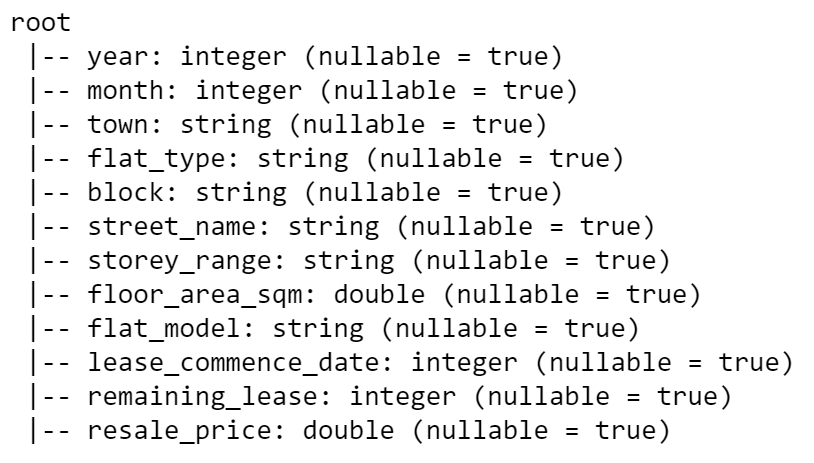

printSchema() is used to show the datatype of each feature in the dataframe. The dataframe consists of features in integer, double and string. 

### 1.3 Understand the Data <a id="part1.3"></a>

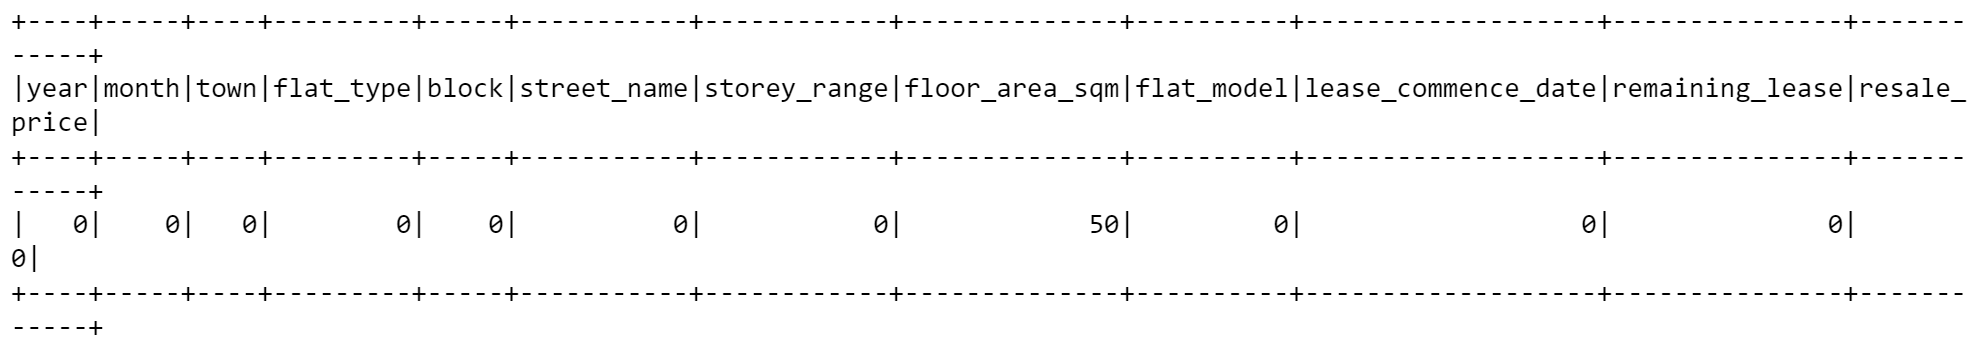 

The result shows an overview count of null values in each feature in the dataframe. There are 50 null values in 'floor_area_sqm'.

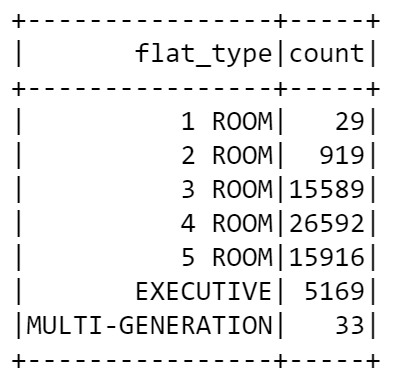

This shows the count of HDB transactions for each flat type. 4 ROOM has the highest count, signifying its popularity among the different flat type. 

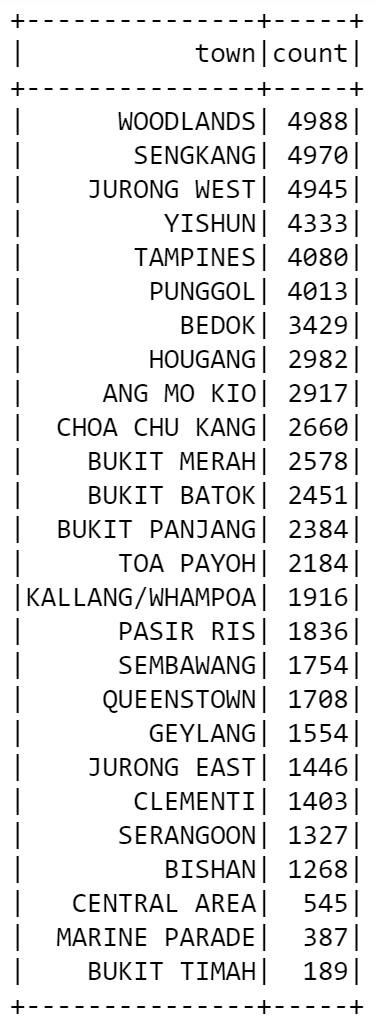

This shows the count of HDB transactions in each town in descending order. Woodlands has the highest number of transactions of 4988 while Bukit Timah has the lowest number of transactions of 189. 

### 1.4 Formulate a Value Based Problem <a id="part1.4"></a>

In Singapore, resale prices of HDB resale flats are affected by multiple factors. 

A linear regression model is used to predict the resale prices of HDB resale flats excluding resale prices more than 1 million based on the factors: 
- town
- flat_type
- storey_range
- floor_area_sqm
- flat_model
- remaining_lease

## 2. Exploratory Data Analysis and Data Cleansing <a id="part2"></a>

### 2.1 Interesting Trends <a id="part2.1"></a>

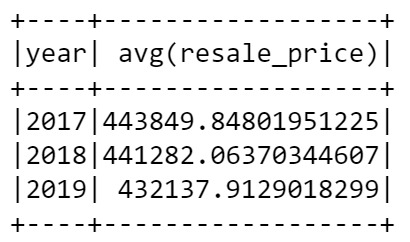

As year increase, average resale price decreases. 

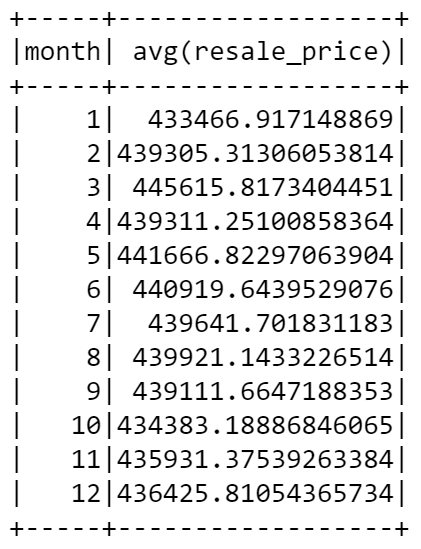

Average resale price differs throughout the year, with not much difference between them. Average resale price is highest in March and lowest in January. 

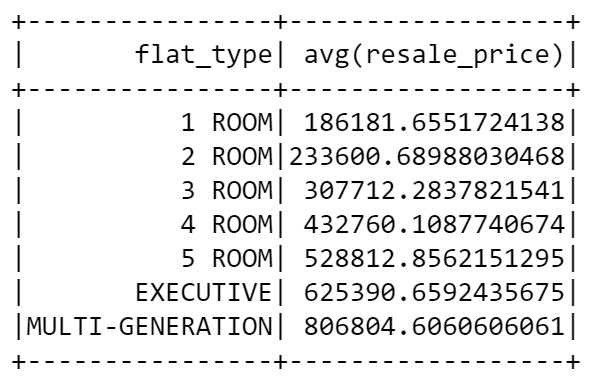

As the size of flat increases, average resale price increases. 

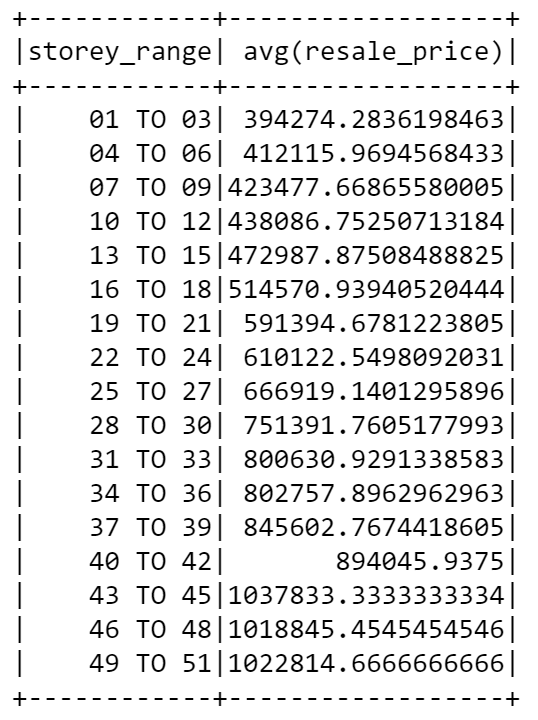

As storey range increases, average resale price increases. 

### 2.2 Anomalies <a id="part2.2"></a>

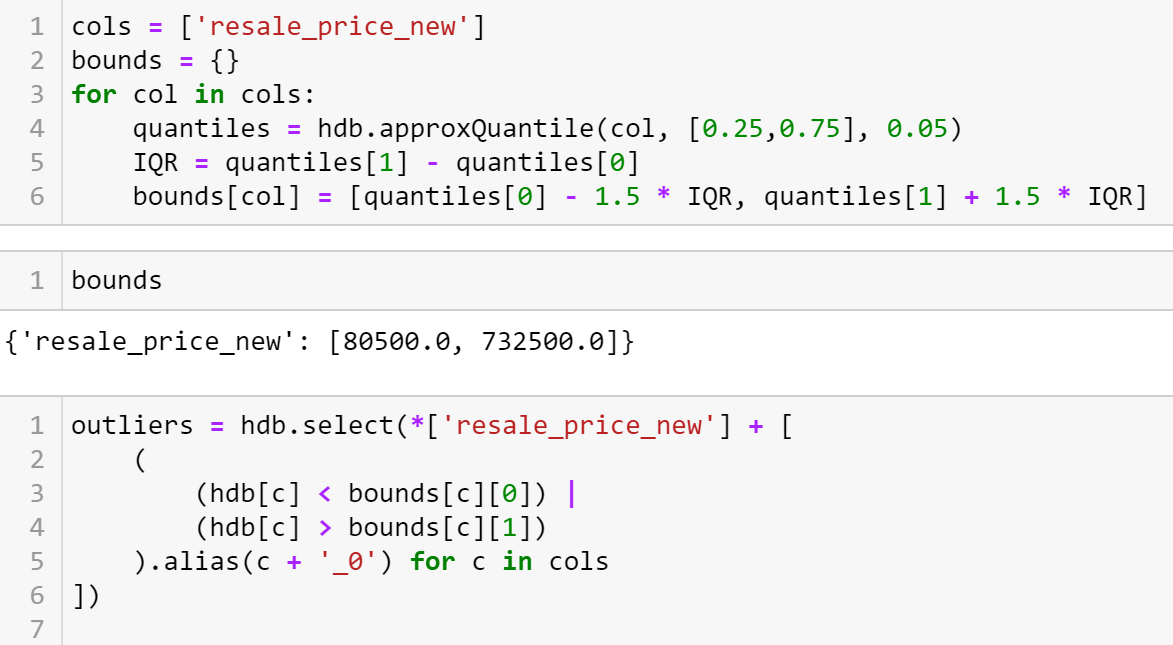

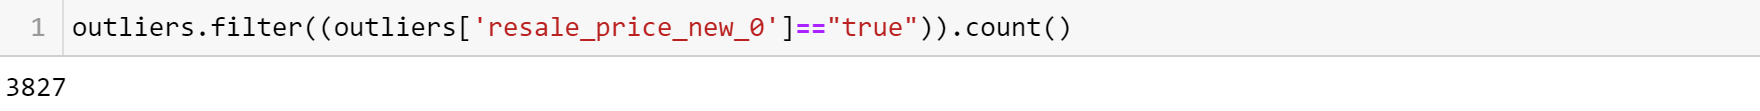

Pressence of outliers were checked for in target variable 'resale_price_new', where they are present. 

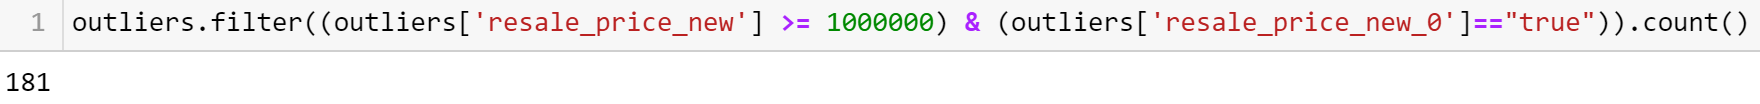

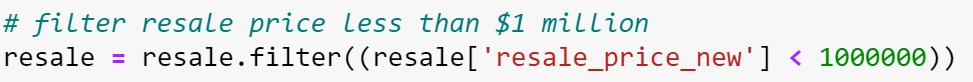

Outliers of 'resale_price_new' more than 1 million were checked for using a filter. There is 181 outliers of resale prices more than 1 million. These values were filtered out as 181 values are insignificant in this dataframe. 

### 2.3 Features Conversion <a id="part2.3"></a>

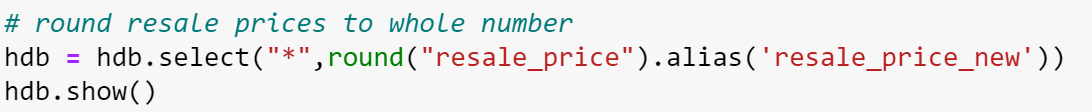

With reference to printSchema() under 1.2, 'resale_price' has datatype of double. 'resale_price' is rounded to the nearest whole number and the new column created is renamed as 'resale_price_new'. 

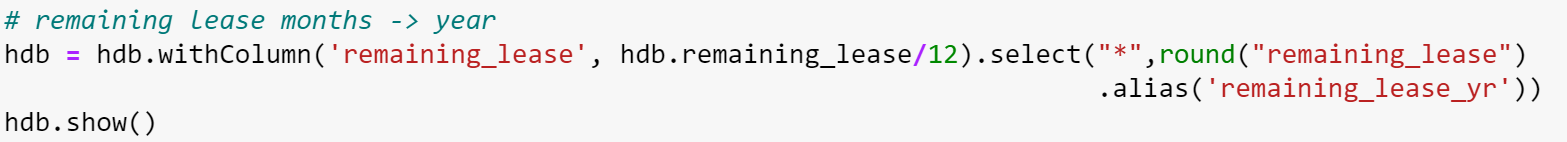

Remaining lease initially in months is converted to years by dividing by 12 and is rounded to the nearest whole number where a new column with the rounded values is created and renamed as 'remaining_lease_yr'. 

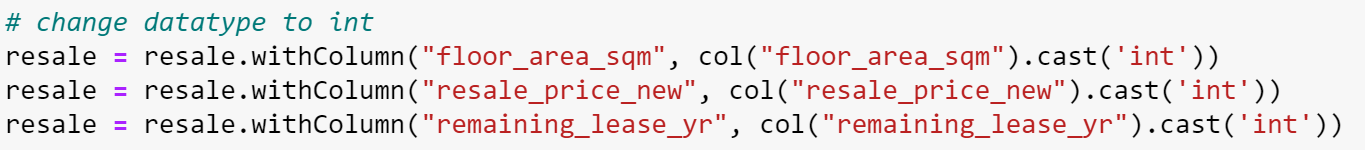

The features are converted to interger for better readility and use in mathematical operations for creation of new variable 'price_per_sqm' with reference to 2.5. 

### 2.4 Missing Value Treatment <a id="part2.4"></a>

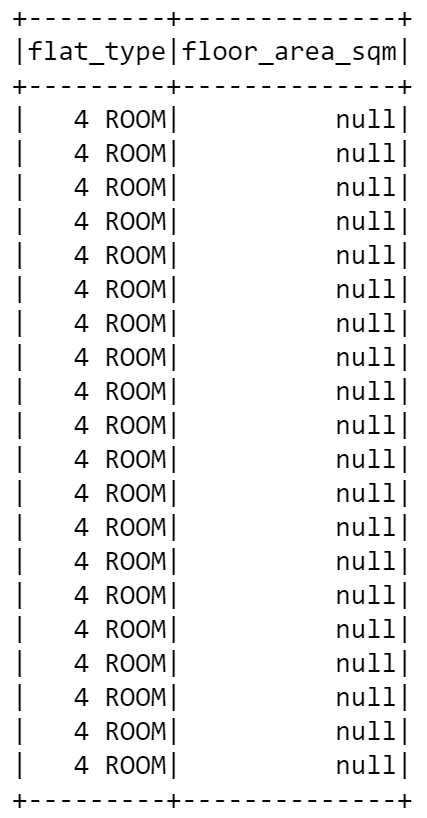

With reference to the null count in 1.3, a filter is used to identity the 'flat_type' of the null values in 'floor_area_sqm'. It shows that null values are present for 4 ROOM flats. 

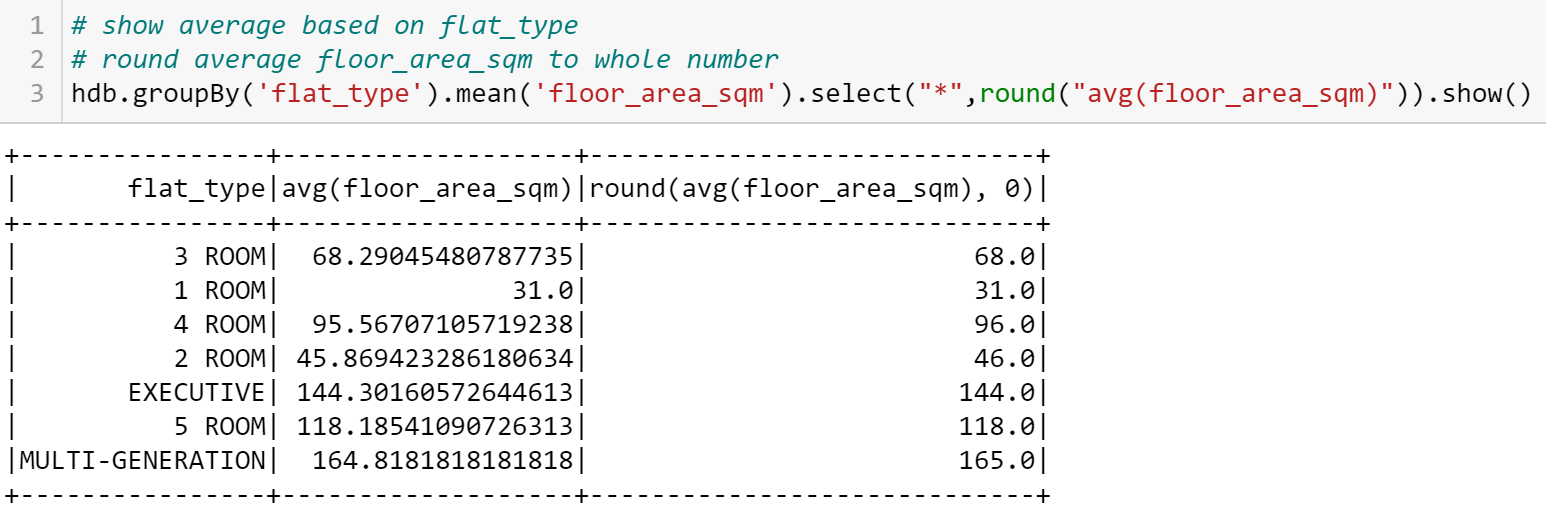

A groupBy function is used to find the average 'floor_area_sqm' based on 'flat_type' and rounded to the nearest whole number. Since the null values in 'floor_area_sqm' are for 4 ROOM flats, the average 'floor_area_sqm' of 4 ROOM of 96 is used for missing value imputation instead of dropping the null values.

### 2.5 Adding / Dropping Features <a id="part2.5"></a>

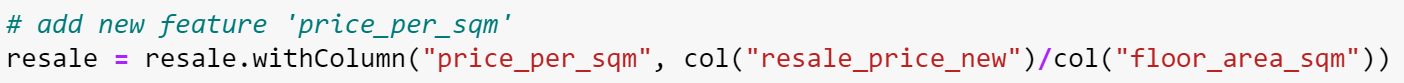

A new feature 'price_per_sqm' is created which shows the price per floor_area_sqm. This is derived using resale_price_new divide floor_area_sqm. 

This feature helps improve the overall performance of the model in predicting HDB resale prices. 

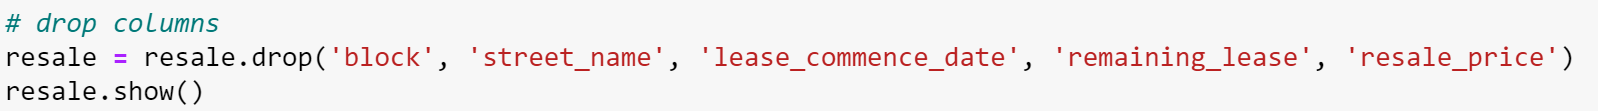

These columns are dropped as it has less impact in the prediction of hdb resale prices. 'remaining_lease' and 'resale_price' are dropped as there are duplicates of these features when new columns are created from rounding of these two features to whole numbers. 

## 3. Data Wrangling and Transformation <a id="part3"></a>

### 3.1 Categorical Data <a id="part3.1"></a>

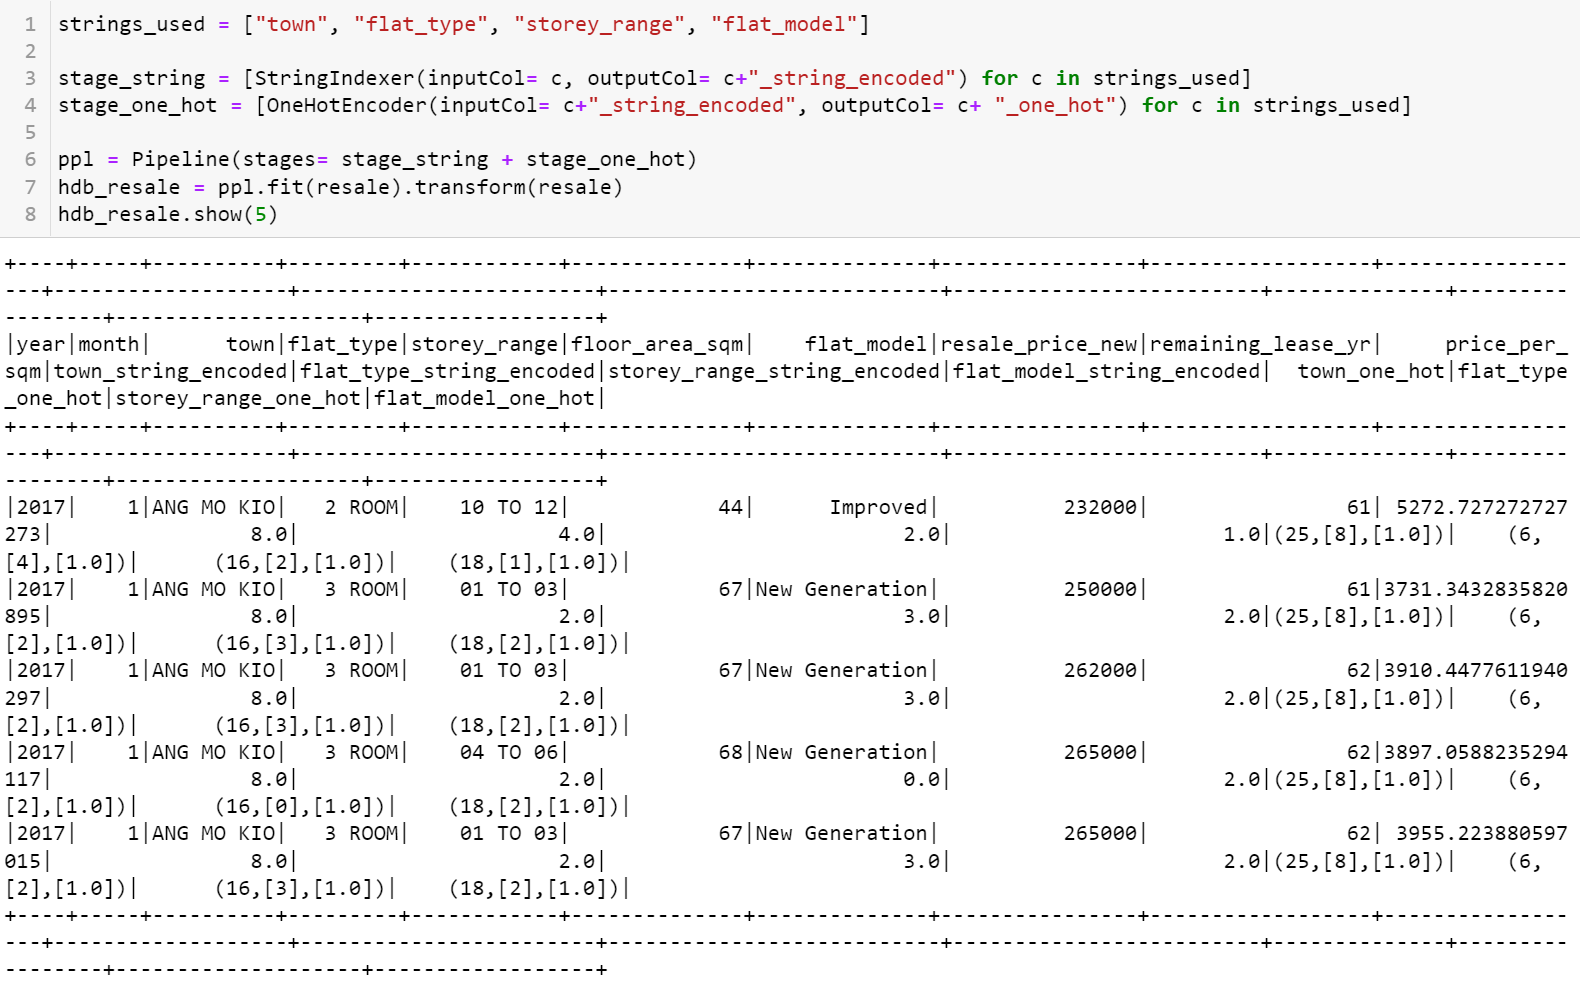

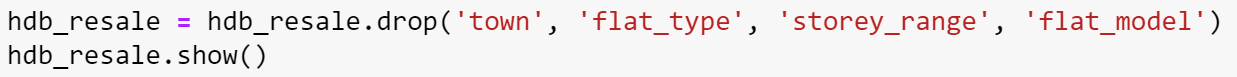

String indexer and one hot encoder are used to encode categorical features 'town', 'flat_type', 'storey_range', and 'flat_model'. Pipeline is used to transform these categorical data to numeric values. The final encoding results are shown. 

String indexing and one hot encoding creates new columns, therefore original columns are then dropped.

### 3.2 Scaling <a id="part3.2"></a>

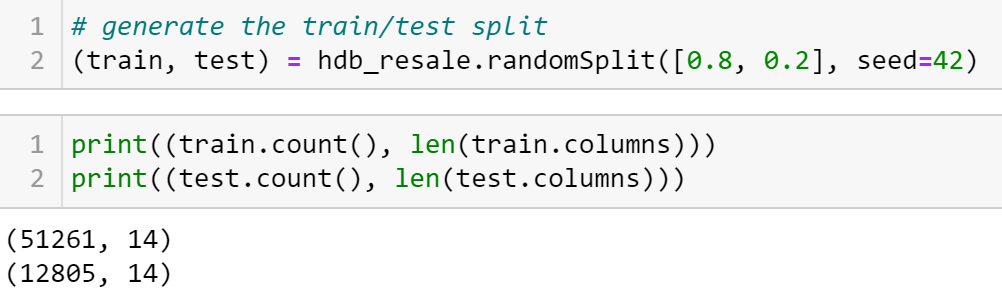

For the train test split, the ratio for train and test data are 80% and 20% respectively. Train data consists of 51261 rows and 14 columns while test data consists of 12805 rows and 14 columns. 

A train test split is done before a list is created for features used in the linear regression model to predict resale price.

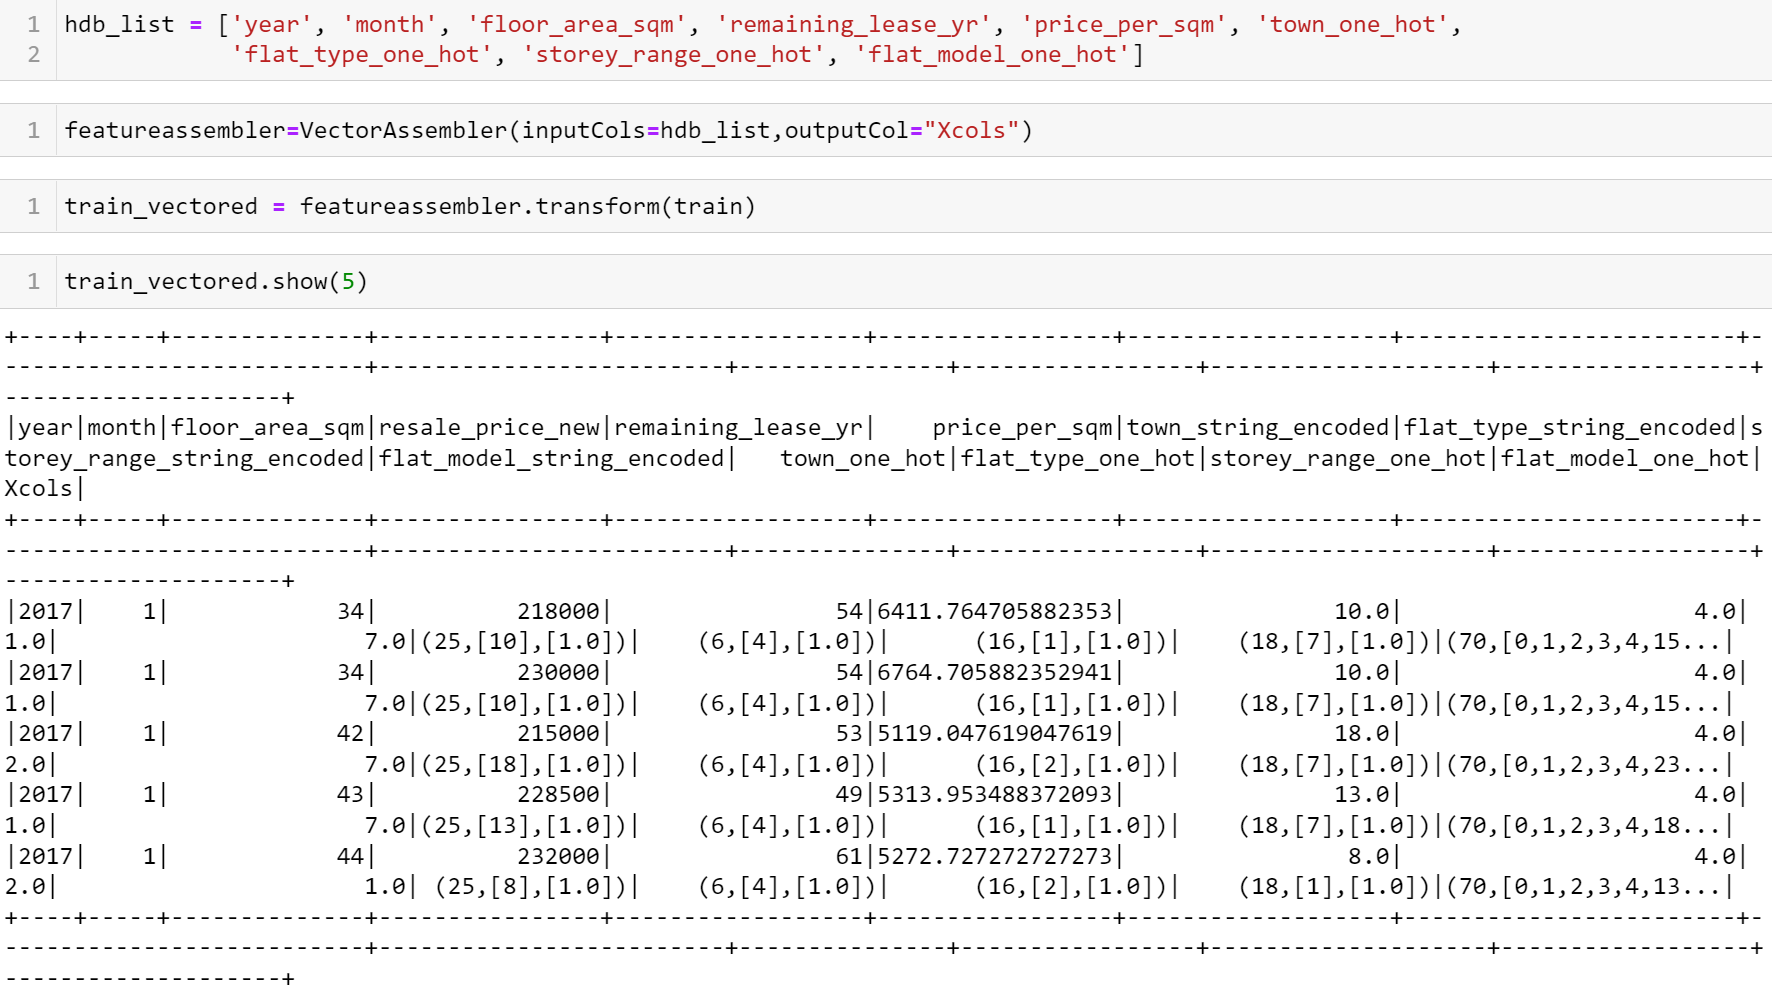

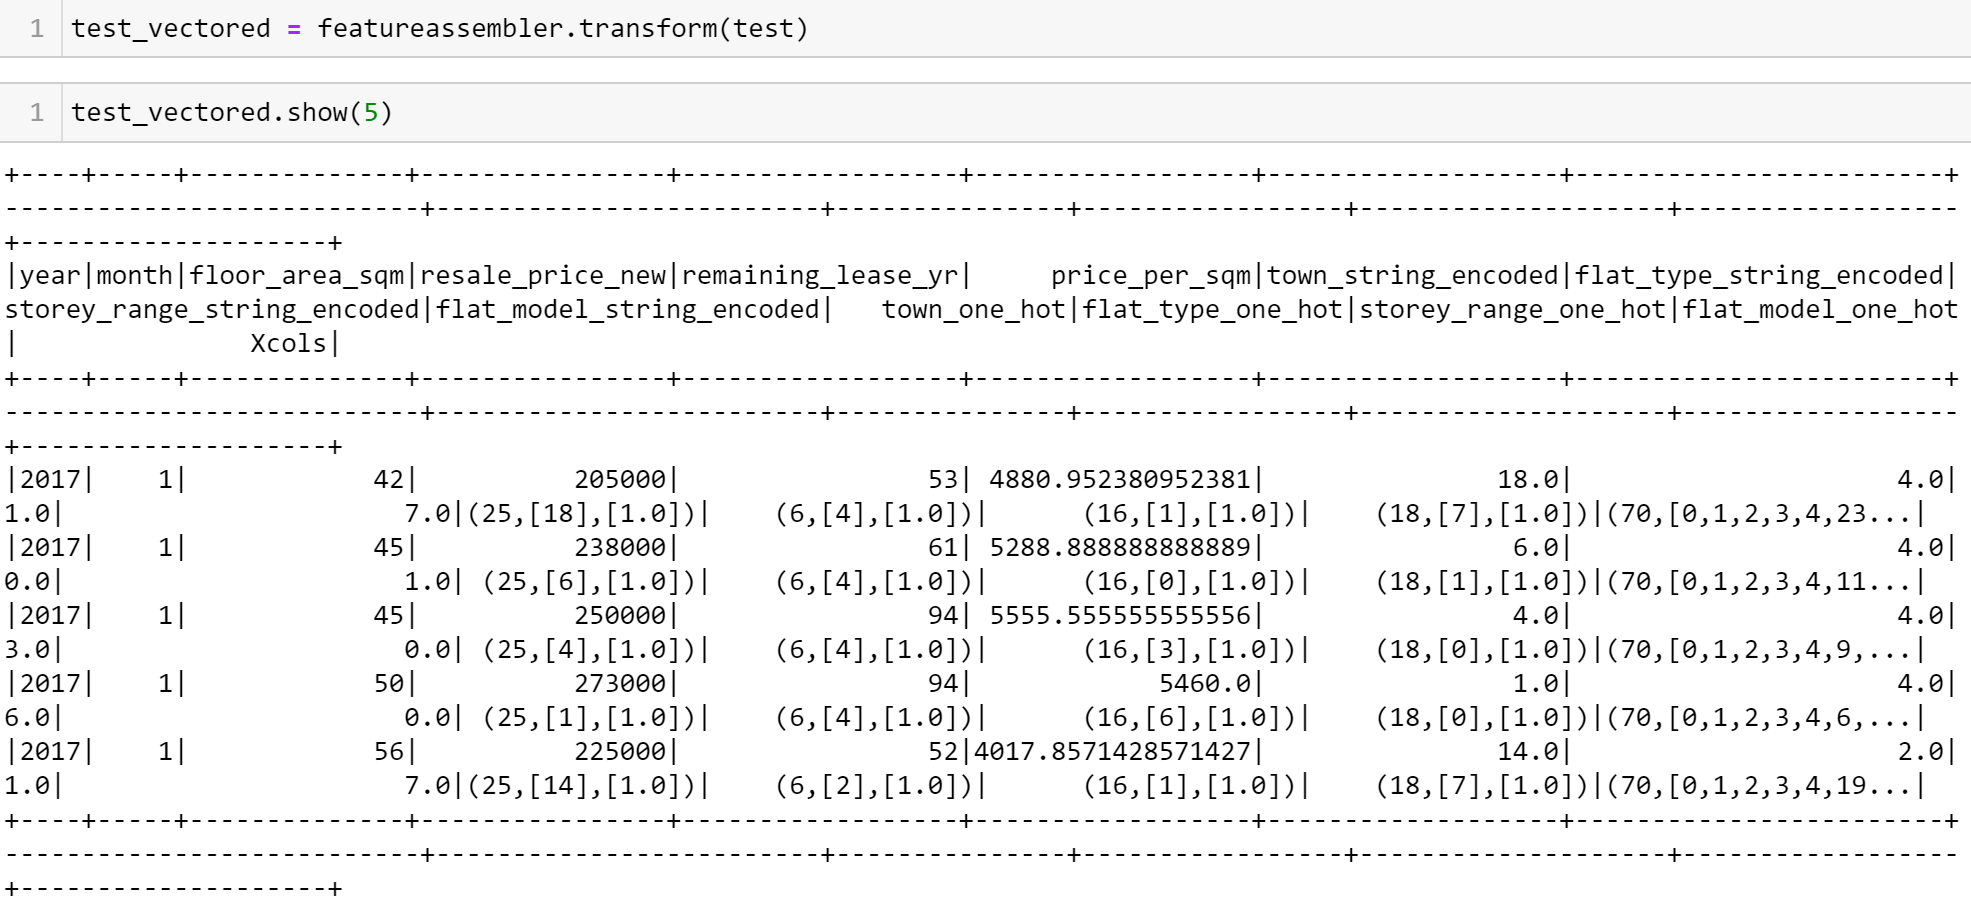

A list 'hdb_list' is created where features are selected for use in the linear regression model for the prediction of resale price which are then pass in as inputCols in the VectorAssembler. VectorAssembler consolidate all the values needed to predict resale price into a new column 'Xcols'. 

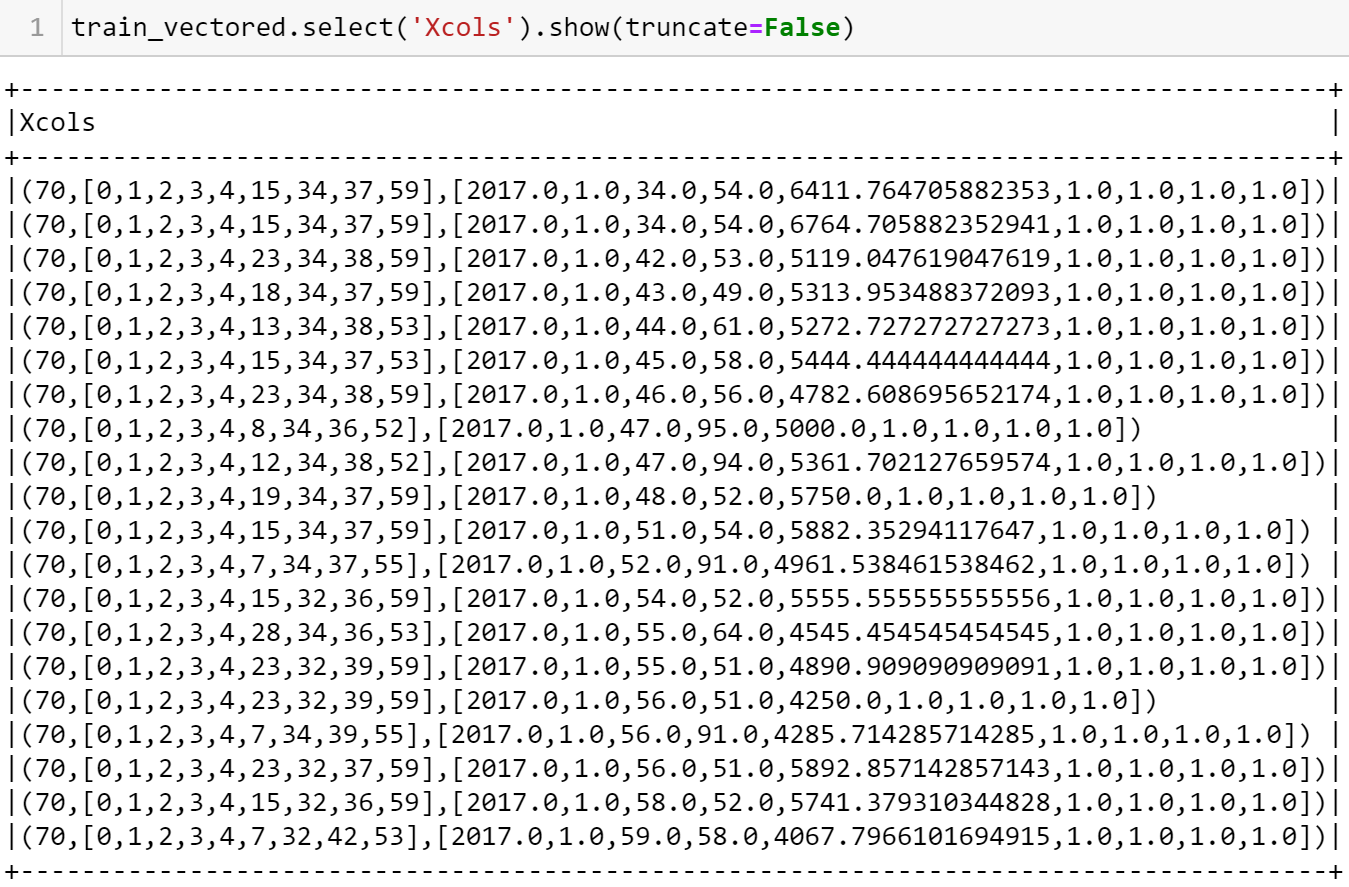

This shows all the values in the column 'Xcols' without truncation. This checks that the target variable 'resale_price_new' is not present in 'train_vectored', causing data leakage. 

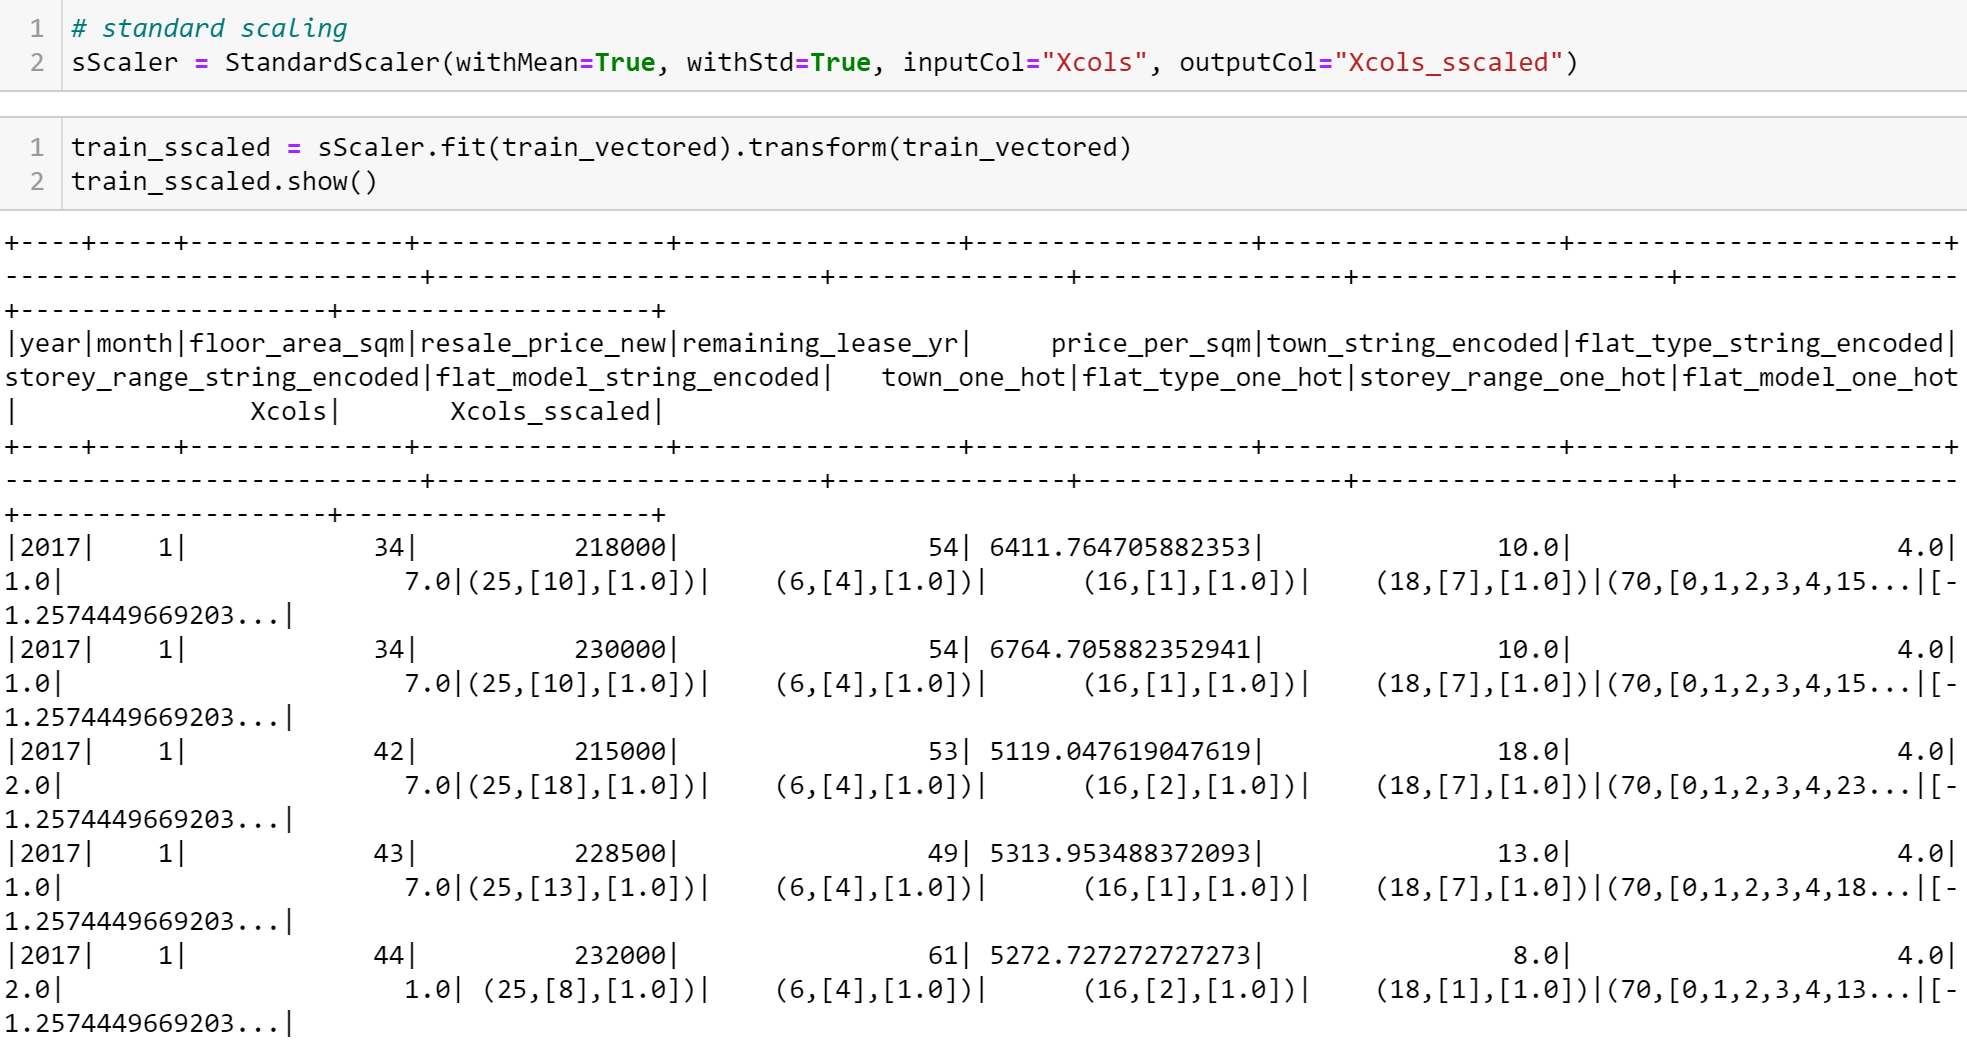

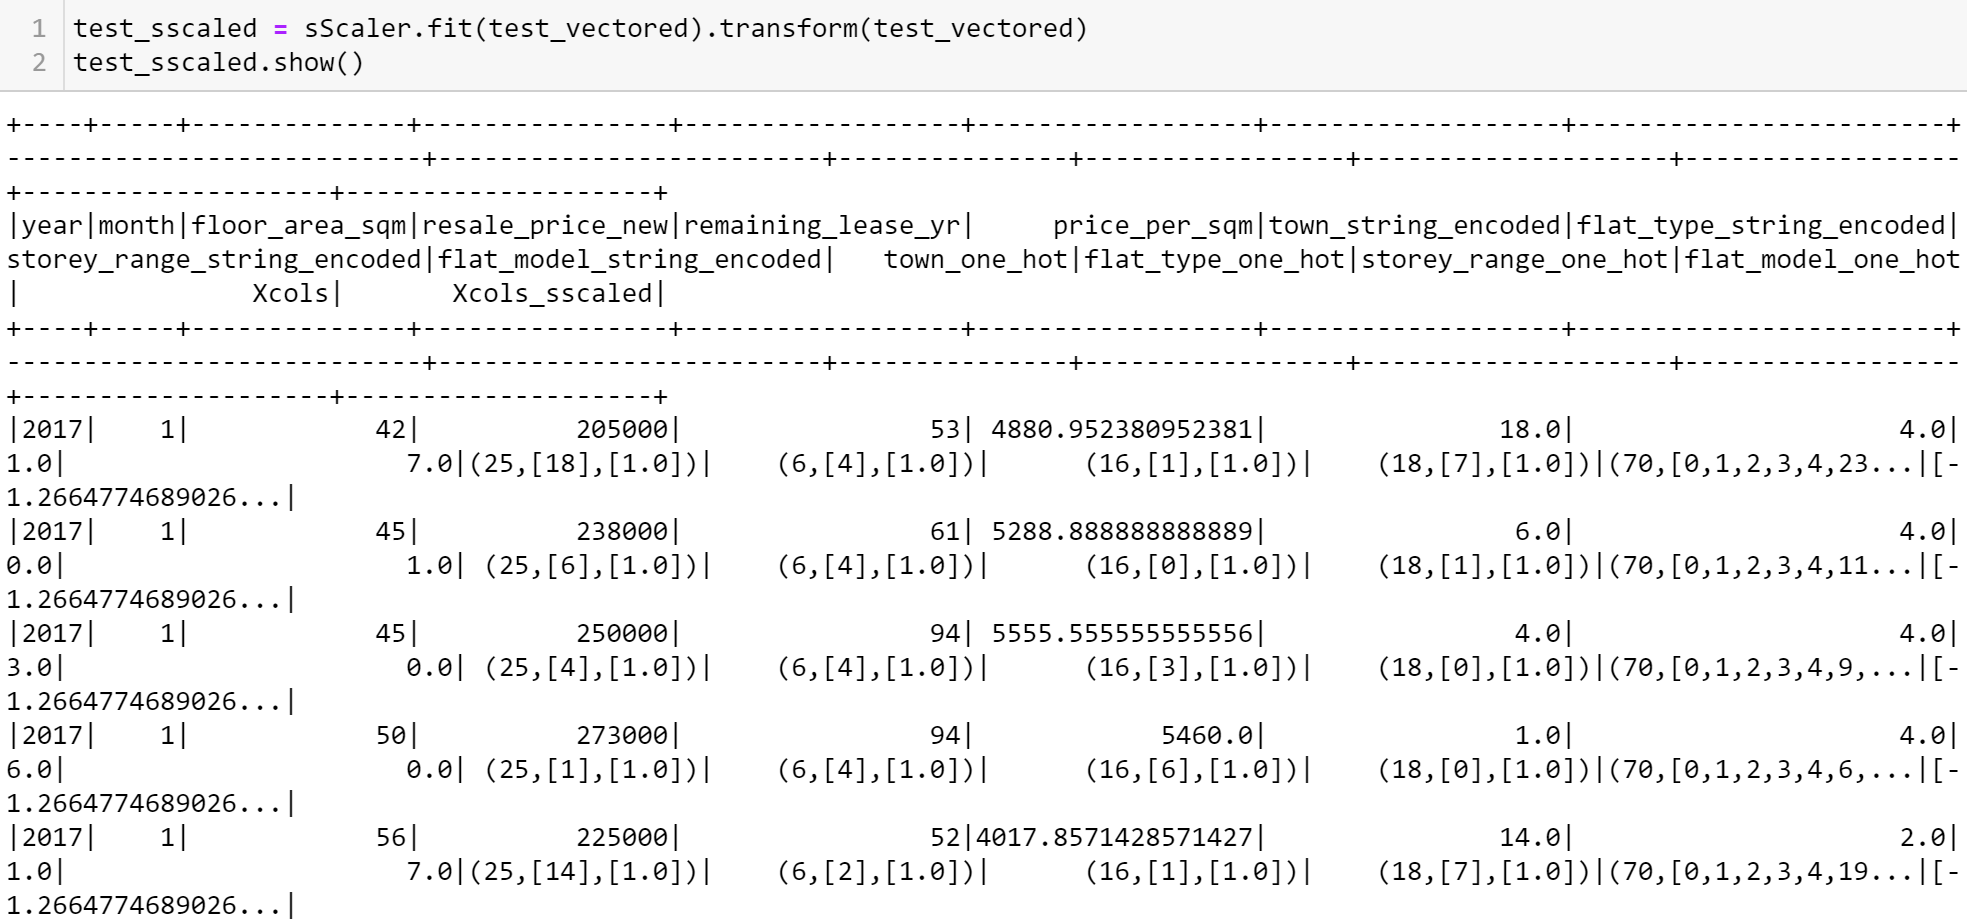

Standard scaling is performed to scale the numerical variables for better comparative analysis. 'Xcols' is passed in as inputCols and 'Xcols_sscaled' is created after scaling. 

## 4. Machine Learning Modelling <a id="part4"></a>

### 4.1 Show Count of Rows and Columns <a id="part4.1"></a>

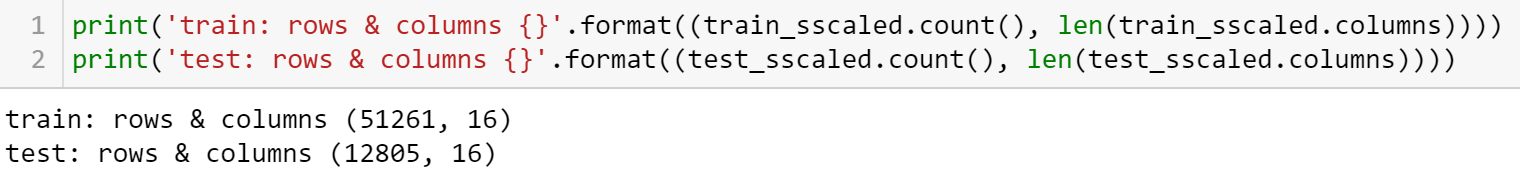

This shows the final count of rows and columns for both train and test respectively. Train data has 20955 rows and 23 columns while test data has 8981 rows and 23 columns.

### 4.2 Sample of 10 Rows before Modelling <a id="part4.2"></a>

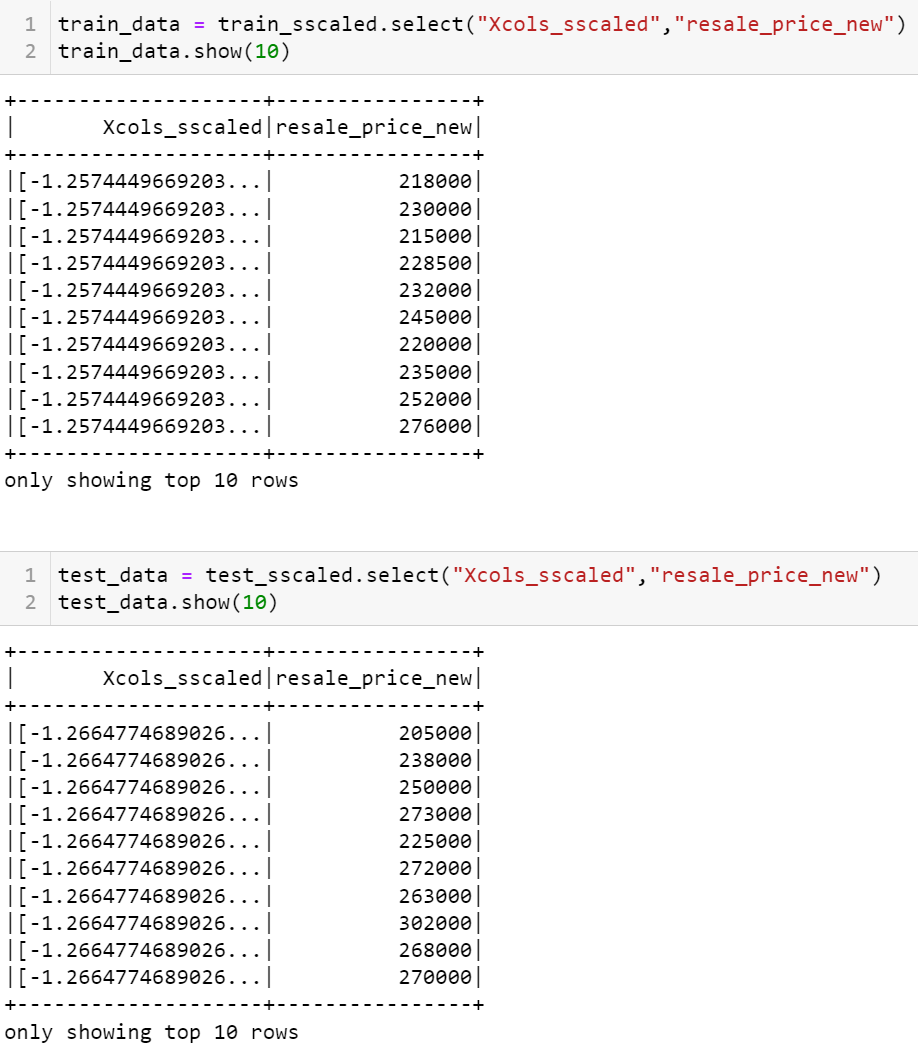

The two columns 'Xcols_sscaled' and 'resale_price_new' are selected from 'train_sscaled' and assigned to new variable 'train_data'.

The two columns 'Xcols_sscaled' and 'resale_price_new' are selected from 'test_sscaled' and assigned to new variable 'test_data'. 

Then, the first 10 rows are displayed for both the train and test data.

### 4.3 Build the Predictive Model <a id="part4.3"></a>

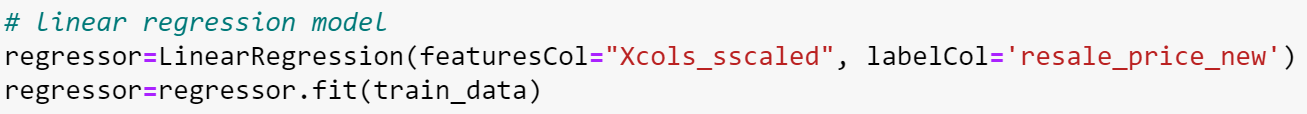

'Xcols_sscaled' and 'resale_price_new' are passed into the regressor as featuresCol and labelCol respectively in the linear regression model for prediction of resale price. 

## 5. Model Evaluation and Selection <a id="part5"></a>

### 5.1 Utilize Model Metrics for Evaluation <a id="part5.1"></a>

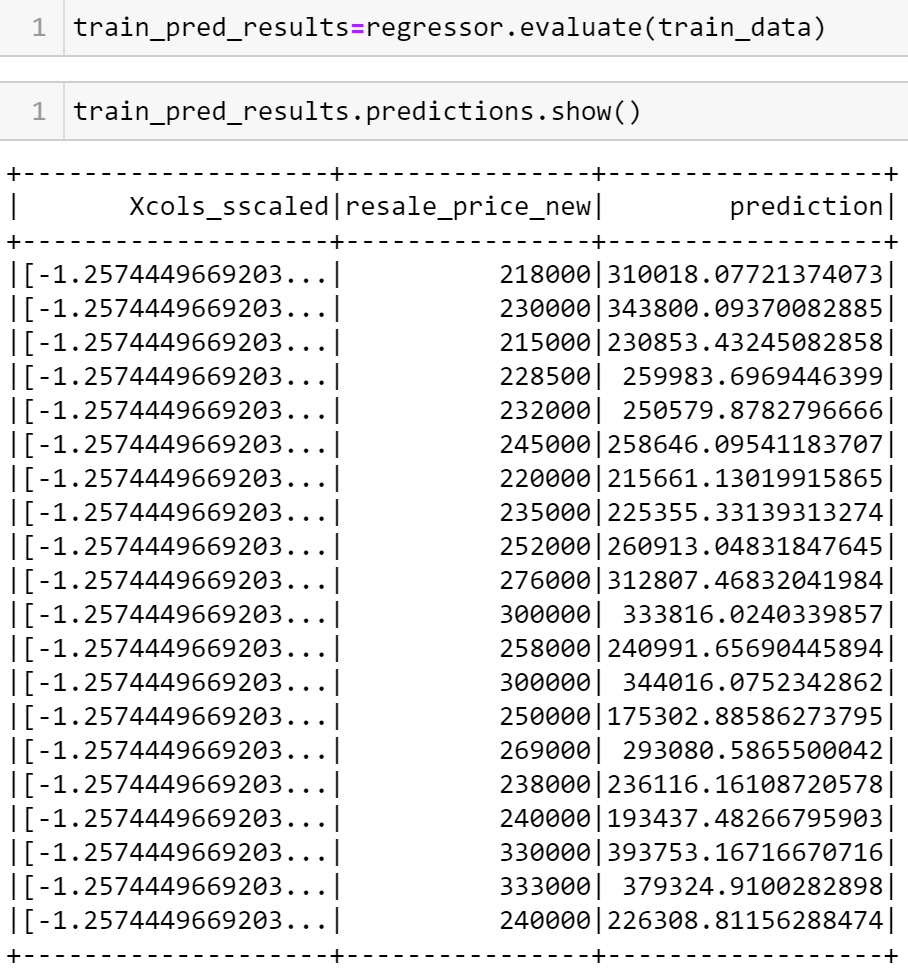

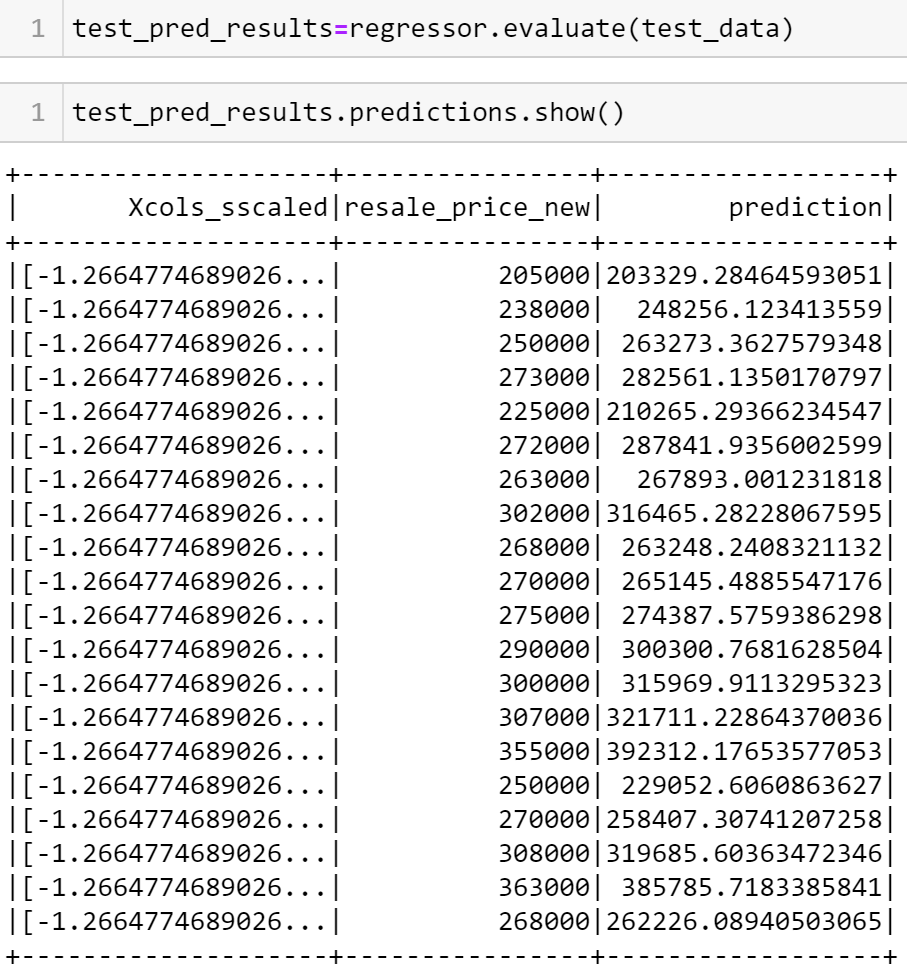

This shows the evaluation of predicted values as compared to the actual resale price in the dataframe for both train and test data. 

### 5.2 Compare Models and Decide on Final Model <a id="part5.2"></a>

This shows the evaluation results of the prediction compared to the 'true' value 'resale_price_new'. 

Different methods were tried to get the best results. 

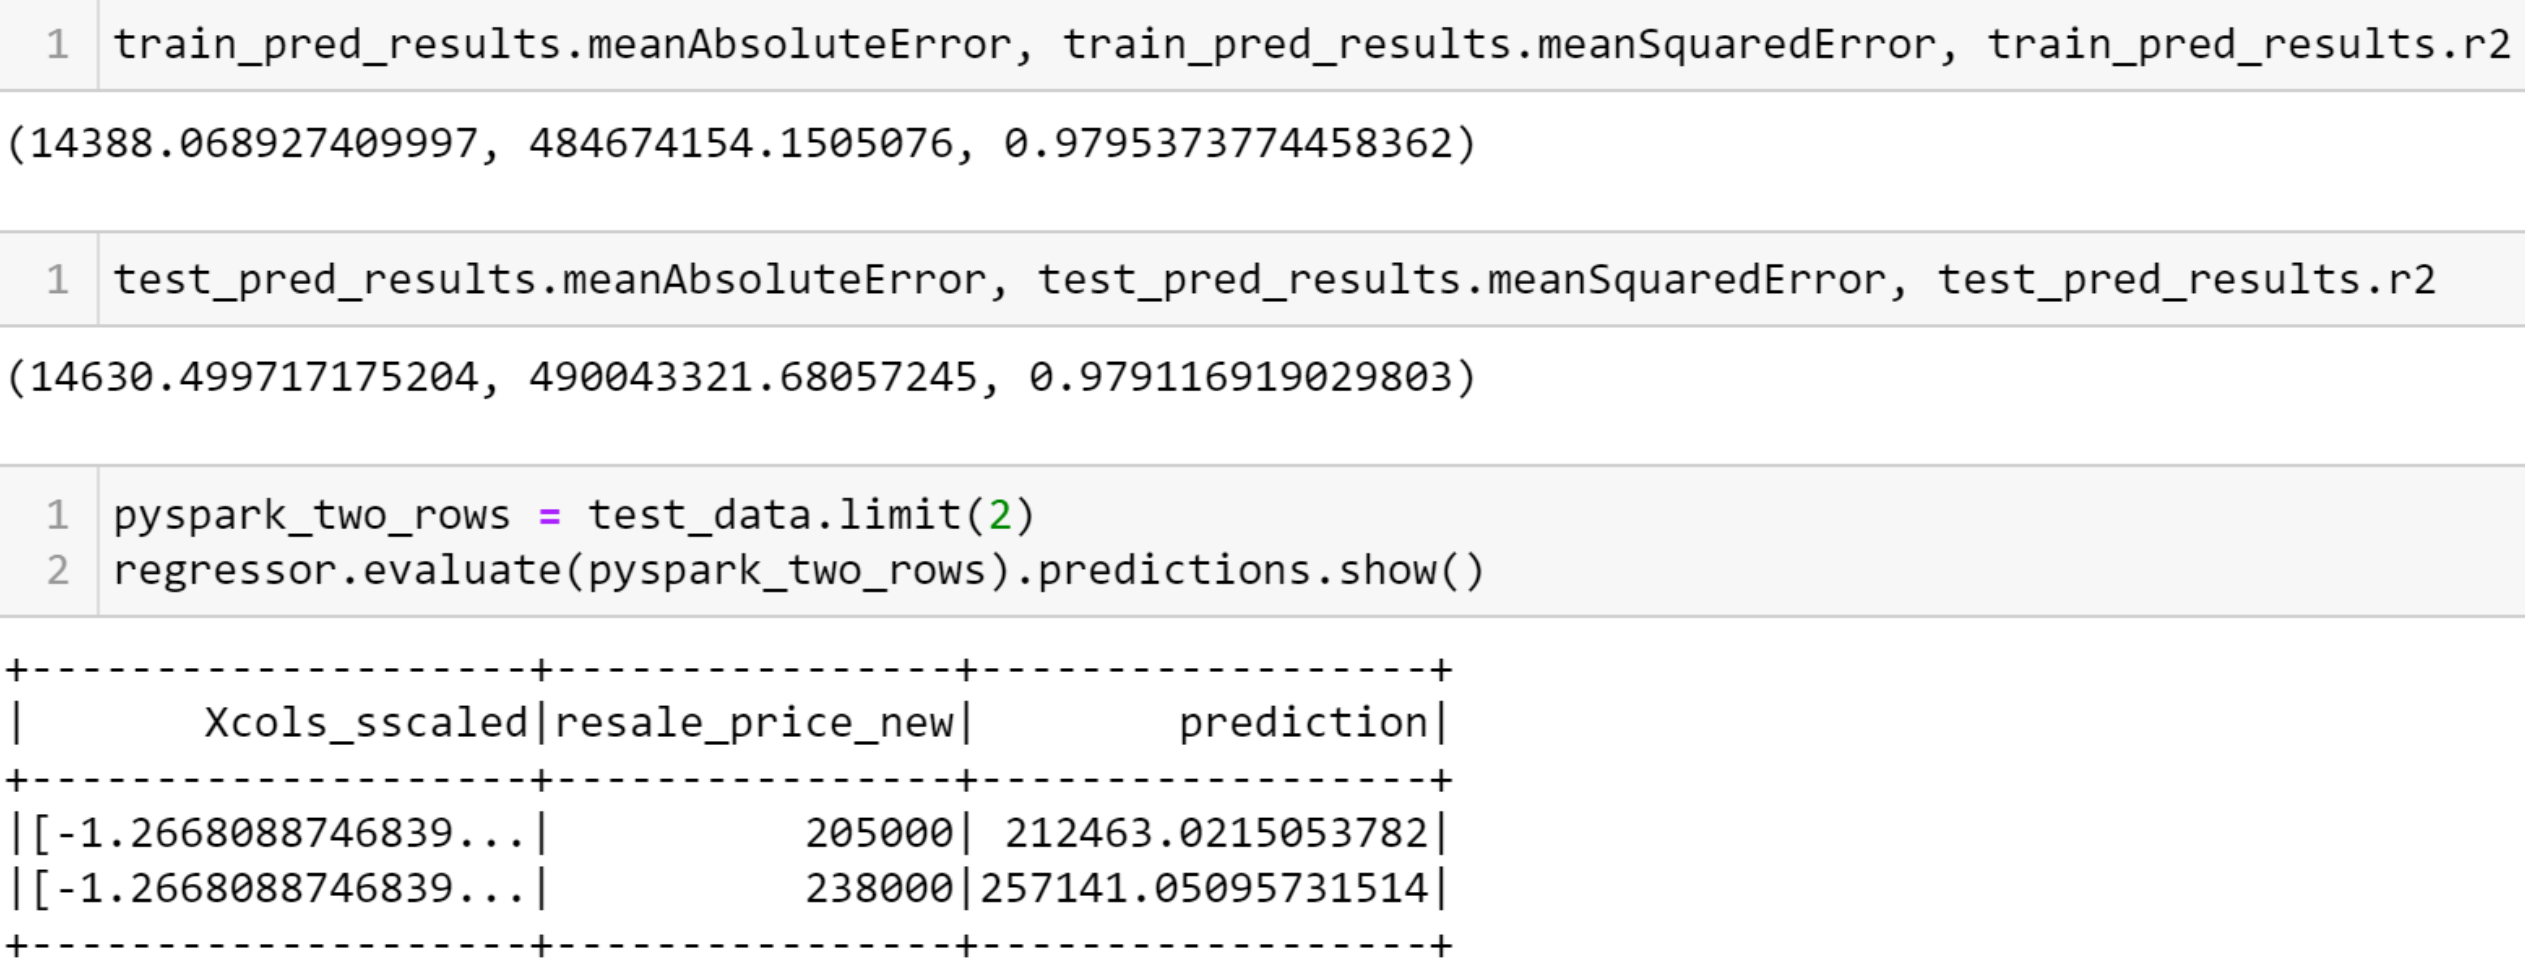

This shows the results of the regression model with no filtering. The prediction values of resale prices in this model was the furthest away from the 'true' resale price. 

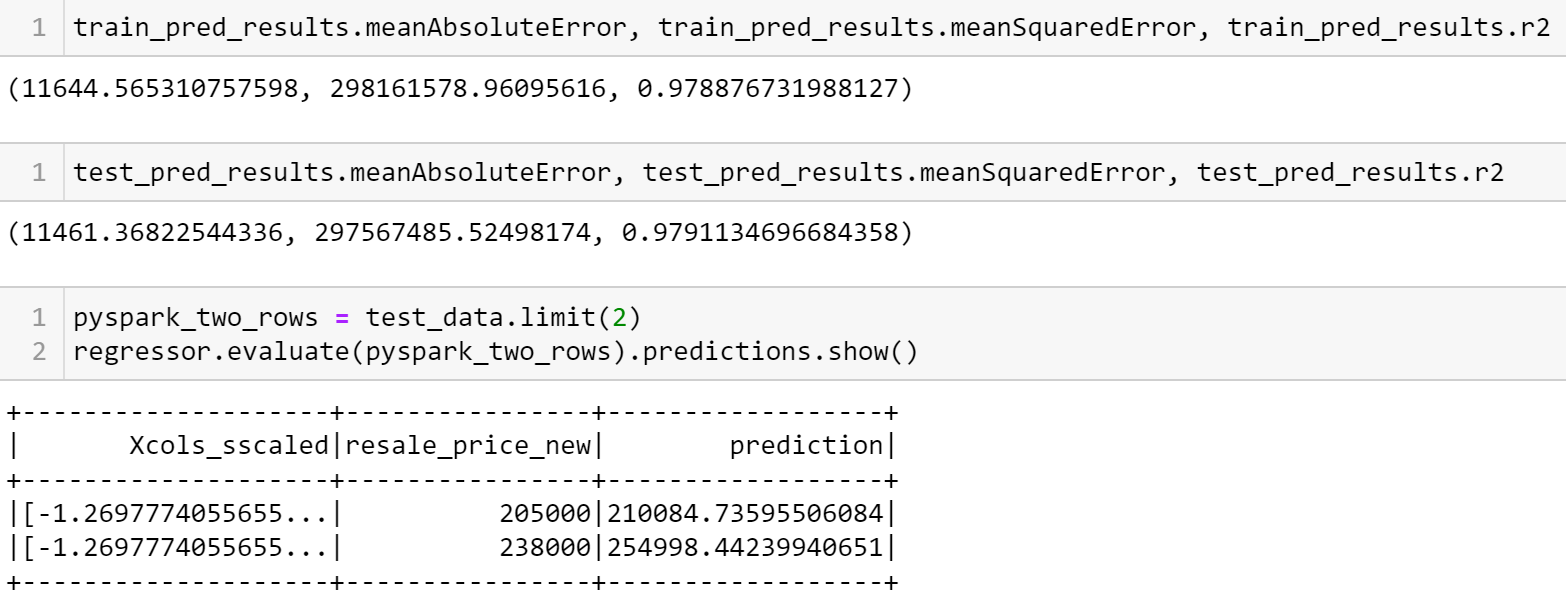

This shows the results of the regression model where resale price <732500 is filtered as well as '1 ROOM' and 'MULTI-GENERATION' flat types. 732500 is derived from the upper quartile of the 'bounds' with reference to 2.2.  

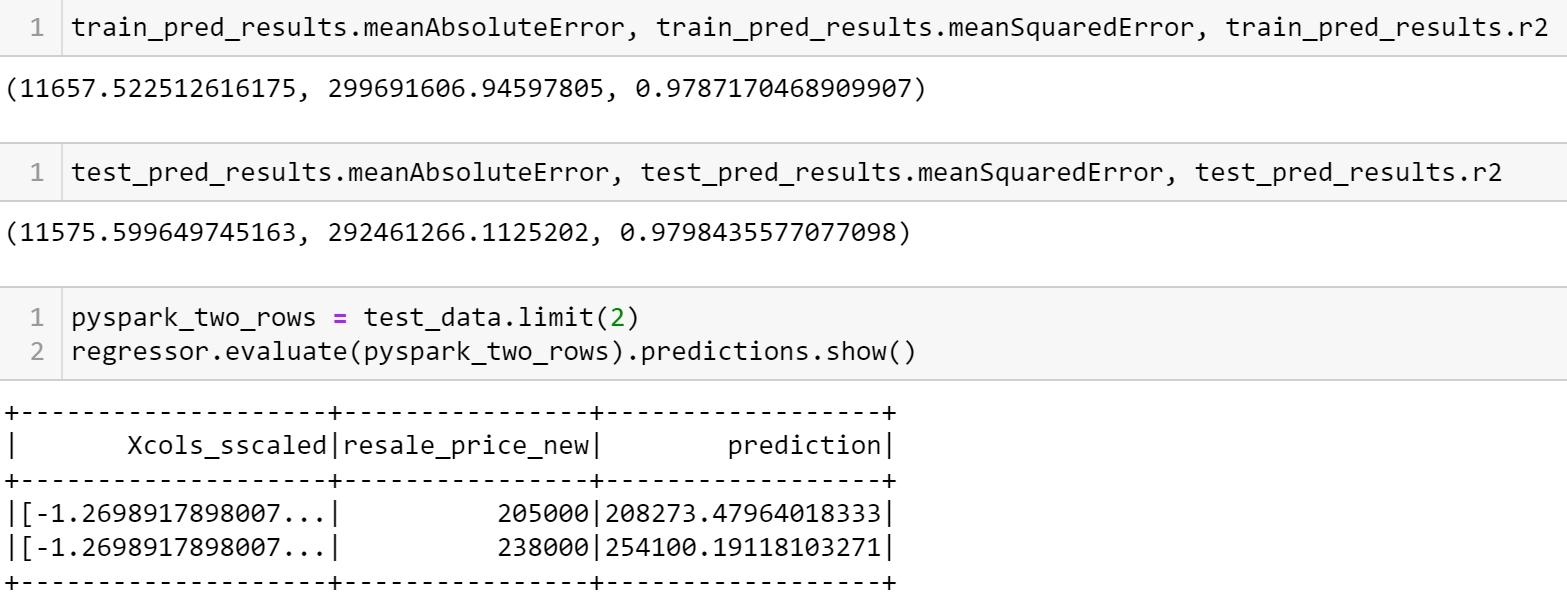

This shows the results of the regression model where resale price <732500 is filtered. With reference to 2.2, all the outliers are >732500. Removing of all outliers were tried to see if it provided a good prediction. 

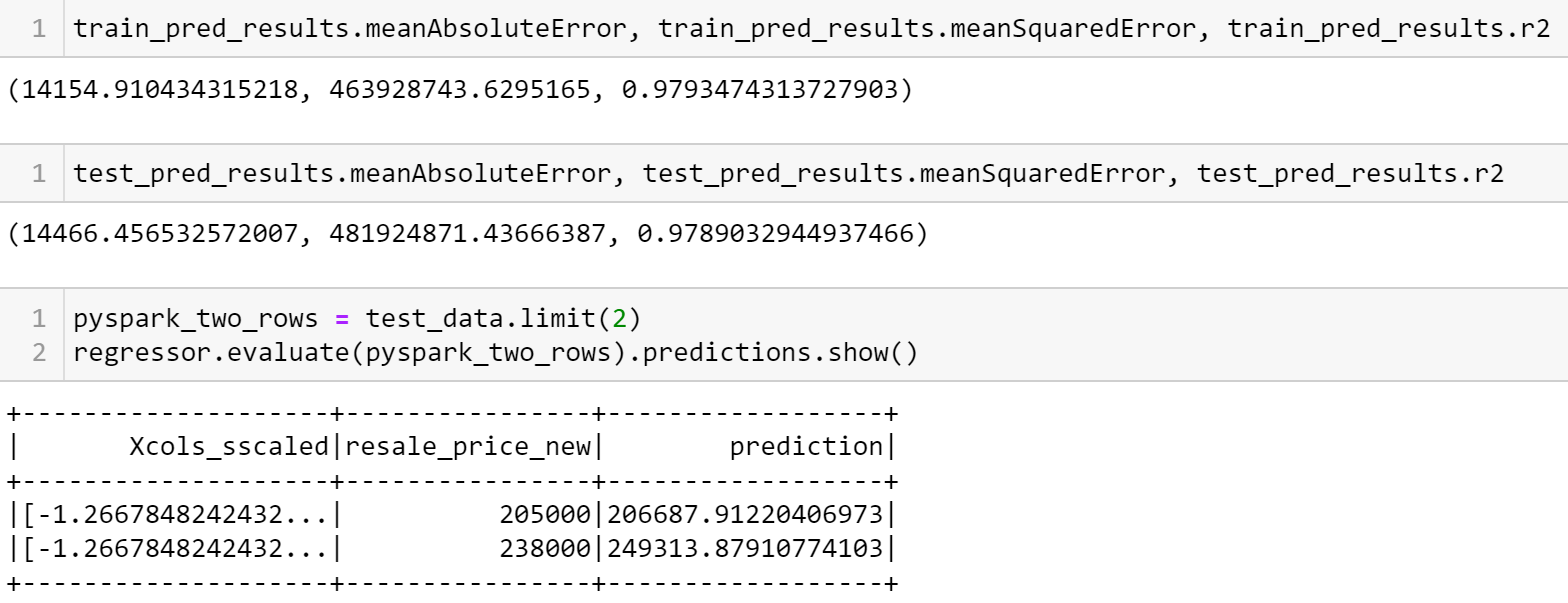

This shows the results of the regression model where resale price <1000000 is filtered as well as '1 ROOM' and 'MULTI-GENERATION' flat types. 

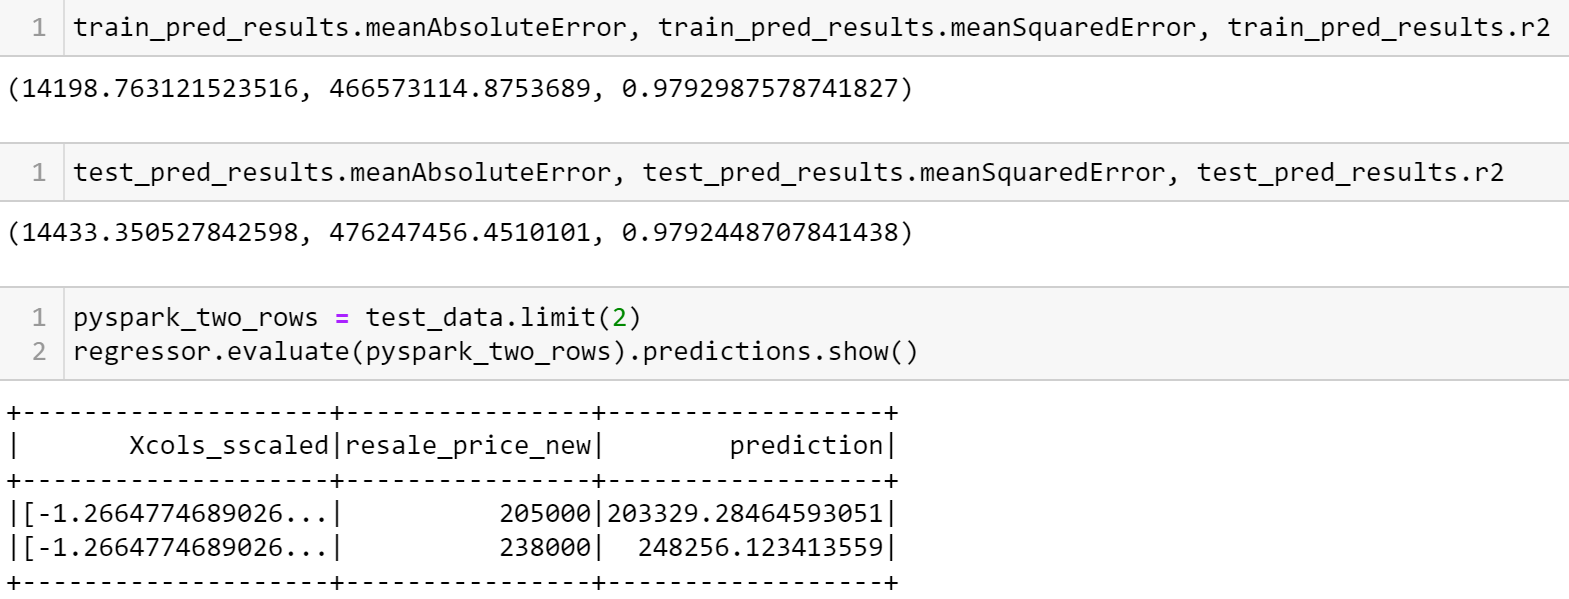

This shows the results of my regression model where resale price <1000000 is filtered. 

The last model is chosen as my preferred model as the prediction is much closer to its target variable 'resale_price_new'.

## 6. Summary and Further Improvements <a id="part6"></a>

### 6.1 Summarize Findings <a id="part6.1"></a>

- Data exploration to observe trends


- Outliers present in 'resale_price_new', filter was used to find the count of outliers that is >= 1000000


- 'remaining_lease' converted from months to years


- 'floor_area_sqm' null values are of 4 ROOM flats and are inputed with 96 (average floor area of 4 ROOM)


- 'price_per_sqm' created representing resale price per floor area sqm


- Unnecessary columns which were not useful in resale price prediction were removed -> 'block', 'street_name', 'lease_commence_date'


- 'remaining_lease' and 'resale_price' removed as there are duplicates which were created from the rounding of these two features 


- Filter resale prices < 1000000


- Categorical encoding using string indexing and one hot encoding for 'town', 'flat_type', 'storey_range', 'flat_model'


- Train test split (80% train data and 20% test data)


- VectorAssembler


- Standard scaling


- Show count of rows and columns of train and test data


- Linear Regression Model


- Evaluation


- High positive correlation between 'price_per_sqm' and target 'resale_price_new'

### 6.2 Possible Further Improvements <a id="part6.2"></a>

Good to have other factors affecting resale prices such as convenience distance to integrated transport hub / MRT, distance to Central Business District (CBD) as these features might help to improve the prediction model. 

Geocoding combining block and street name to derived latitude and longitude. 

[Back to top (code)](#top)

### "Unlisted" Youtube Link to Video Presentation

In [75]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/ZTzl-AFVGGM